# Agent environment with bitflipping actions, using DQN with HER

## Neural network model details
 * Input: $\mathbb{R}^n$ vector representing the bit sequence (e.g. $00011 \sim (0, 0, 0, 1, 1)$)
 * Output: $\mathbb{R}^{n^2}$ vector of the $Q$-values
    * The first index corresponds to integer $\geq 0$ representing the index of the bit being flipped
    * The second index corresponds to the goal
    * So $\text{model}(s)[a][g]$ will be the $Q$-value
 * Architecture: Simple MLP

## Goals
Here, the goal determines the reward function $R_g(s, a) = R(s, a, g)$. In our case, the goals are integer $0 \leq g \leq n-1$, where $S_g = \{s \in S| d_\text{taxicab}(s, t) \leq g\}$
$$
R_g(s, a) = \begin{cases}
1 & \text{If }s \in S_g^c \rightarrow s' \in S_g \\
-1 & \text{If }s \in S_g \rightarrow s' \in S_g^c \\
0 & \text{Otherwise}
\end{cases}
$$
where $s',t$ are the new state (new bit sequence), target state (target bit sequence) respectively. Note that when $g=0$ it reduces to our usual reward function.

## Training method
DQN with HER (OpenAI paper)
   * Exploration step -> update Q network -> validation step

**Exploration step**
We initialize 16 agents starting at random starting states (for each agent), and a set of goals (of size 10) drawn uniformly for each agent. The agent will take action according to the first goal, and the rewards for the other randomly sampled goal(s) will be recorded. The actions will be according to the DQN agent, and with probability $\epsilon$, a random action will be picked uniformly. We add this to the experience buffer.

**Update Q network**
Update the DQN to match Bellman's equation using a randomly sampled batch size ($=128$), and this is done with gradient descent.

**Validation step**
Access the performance of the learnt policy. Initialize 1024 random starting states, and let the agent fully decide the actions (we do not replace actions with probability $\epsilon$ with uniform distribution). We also fix the agent to use goal $g=0$. Since this is the validation step, this should not interfere with the training process, and the experience buffer won't be updated.


## Notes
**Optimal agent** For an optimal agent, $E[\text{steps}] = \frac{1}{2^n}\sum_{k=0}^n \dbinom{n}{k}k = \frac{n}{2}$. We expect the average number of steps to be close to $\frac{n}{2}$ if an optimal agent is chosen.

**Non-HER goal based agent** When HER is not used, we only record the experience for the agent according to the goal the agent is executing. This corresponds to num_goals=1 (do not record extra goals).

In [1]:
from src.environments.env_bit_sequence_flipping_goals import FlippingBitSequenceEnvWithGoals
from src.agents.agent_dqn_her import DQNHERAgent
from src.models.model_dqn_bitflipping_goals import BitFlippingDQNNetworkGoals, BitFlippingDQNNetworkGoalsUVFA
from src.models.buffer_bitflipping_goals import BufferBitflippingGoals
from src.models.buffer_bitflipping_goals_multirew import BufferBitflippingGoalsMultiREW
from src.utils import sample_uniform

import numpy as np
import torch

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda:1")

def train_DQN_HER_agent(n: int, device: torch.device,
    episodes: int=10000, num_explore_agents: int=16, num_valid_agents: int=1024,
    num_goals: int=10, batch_size: int=2048,
    logging_frequency: int=200,
    input_goal: bool=False) -> None:

    # initialize environment, model and agent
    env = FlippingBitSequenceEnvWithGoals(n, device, fix_original_state=False)
    model = BitFlippingDQNNetworkGoals(n)
    model.to(device)
    running_model = BitFlippingDQNNetworkGoals(n)
    running_model.to(device)
    #buffer = BufferBitflippingGoals(n, no_repeat=True, device=device, max_buffer_size=2**15)
    buffer = BufferBitflippingGoalsMultiREW(n, no_repeat=False, device=device, max_buffer_size=2 ** 13)
    agent = DQNHERAgent(model=model, running_model=running_model,
                        buffer=buffer, device=device,
                    action_space_size=n, goal_space_size=n)
    
    target_value = n / 2 if not env.fix_original_state else env.get_initial_distance()

    success_rates = []
    steps_to_success = []
    loss_values = []
    mean_rewards = []
    mean_distances = []
    for e in tqdm(range(episodes)):
        # initial state is numpy array, convert to torch tensor
        state = env.reset(num_agents=num_explore_agents)
        # uniformly and randomly choose goals for the agent to act upon
        #goals = torch.tensor(np.random.randint(0, n, (num_explore_agents, num_goals)), device=device, dtype=torch.int64)
        #goals = torch.zeros((num_explore_agents, num_goals), device=device, dtype=torch.int64)
        #goals = torch.tensor(np.random.choice(n, (1, num_goals), replace=False), device=device, dtype=torch.int64).expand(num_explore_agents, num_goals)
        
        # goals = torch.tensor(np.random.choice(n, (num_explore_agents,), replace=False), device=device, dtype=torch.int64)
        #goals = torch.zeros((num_explore_agents,), device=device, dtype=torch.int64)
        goals = torch.tensor(sample_uniform(n, num_explore_agents), device=device, dtype=torch.int64)

        # let agent act for at most 2 * n steps
        for _ in range(2 * n):  # max time stepss
            with torch.no_grad():
                action = agent.act(state, explore=True, goal=goals) # act with the randomly picked first goal for that agent
                next_state, reward, done, info = env.step(action,
                                    goals=torch.arange(n, dtype=torch.long, device=device).unsqueeze(0).expand(num_explore_agents, n))
                prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
                goal_rewards = info["goal_rewards"] # tensor indicating the reward for each goal
                prev_step_ongoing = ~prev_done



                # record transitions in replay buffer
                if prev_step_ongoing.sum() == 0:
                    pass
                elif isinstance(buffer, BufferBitflippingGoalsMultiREW):
                    agent.remember(state[prev_step_ongoing, :].cpu().numpy(),
                                    action[prev_step_ongoing].cpu().numpy(),
                                    goal_rewards[prev_step_ongoing, :].cpu().numpy(),
                                    next_state[prev_step_ongoing, :].cpu().numpy(),
                                    done[prev_step_ongoing].cpu().numpy(),
                                    None) # record the rewards for all goals (HER)
                else:
                    agent.remember(np.tile(state[prev_step_ongoing, :].cpu().numpy(), reps=(num_goals, 1)),
                                    np.tile(action[prev_step_ongoing].cpu().numpy(), reps=(num_goals,)),
                                    np.concatenate([goal_rewards[prev_step_ongoing, goal_idx].cpu().numpy() for goal_idx in range(num_goals)], axis=0),
                                    np.tile(next_state[prev_step_ongoing, :].cpu().numpy(), reps=(num_goals, 1)),
                                    np.tile(done[prev_step_ongoing].cpu().numpy(), reps=(num_goals,)),
                                    np.concatenate([goals[prev_step_ongoing, goal_idx].cpu().numpy() for goal_idx in range(num_goals)], axis=0)) # record the goal specific rewards (HER)
                state = next_state
                if done.all():
                    break
        
            # replay to update Q network
            loss = agent.replay(batch_size=batch_size, opt_steps=1)
        
        with torch.no_grad():
            mean_distance = env.distance_to_target(state).to(torch.float32).mean().item()

        # now run the agent for at most 2 * n steps to see if it has learned (without random exploration, and without affecting the replay buffer)
        # we use random initial states
        state = env.reset(num_agents=num_valid_agents)
        agent_steps_to_success = np.ones(num_valid_agents)
        for step in range(2 * n):  # max time steps
            with torch.no_grad():
                action = agent.act(state, explore=False, goal=0)
                next_state, reward, done, info = env.step(action)
                prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
                prev_step_ongoing = ~prev_done
                state = next_state

                if step == 0: # if by random chance the agent is already done in the first step, we need to handle this case
                    agent_steps_to_success[prev_done.cpu().numpy()] = 0
                agent_steps_to_success[~done.cpu().numpy()] += 1
                if done.all():
                    break
        success_rate = ((done.sum().item() + 0.0) / num_valid_agents)
        avg_steps_to_success = agent_steps_to_success.mean()
        mean_reward = buffer.get_avg_reward()
        success_rates.append(success_rate)
        steps_to_success.append(avg_steps_to_success)
        loss_values.append(loss)
        mean_rewards.append(mean_reward)
        mean_distances.append(mean_distance)

        if e > 100 and (np.array(steps_to_success[-100:]) < target_value + 1).all():
            print("Early stopping at episode", e)
            print("Episode: {}/{}, Epsilon: {}, Success rate: {:.2f}, Avg steps to success: {:.2f}, Loss: {:.6f}".format(e, episodes, agent.epsilon, success_rate, avg_steps_to_success, loss))
            break

        if (e + 1) % logging_frequency == 0:
            print("Episode: {}/{}, Epsilon: {}, Success rate: {:.2f}, Avg steps to success: {:.2f}, Loss: {:.6f}".format(e, episodes, agent.epsilon, success_rate, avg_steps_to_success, loss))
    
    # plot success rates and steps to success over episodes
    plt.figure(figsize=(24, 16))
    plt.subplot(2, 3, 1)
    plt.plot(success_rates)
    plt.xlabel("Episodes")
    plt.ylabel("Success rate")
    plt.title("Success rate over episodes")
    plt.subplot(2, 3, 2)
    plt.plot(steps_to_success)
    plt.xlabel("Episodes")
    plt.ylabel("Steps to success")
    plt.title("Steps to success over episodes")
    plt.subplot(2, 3, 3)
    plt.plot(steps_to_success)
    plt.ylim(target_value - 1, target_value + 1)
    plt.xlabel("Episodes")
    plt.ylabel("Steps to success")
    plt.title("Steps to success over episodes (Zoom)")
    plt.subplot(2, 3, 4)
    plt.plot(loss_values)
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title("Loss over episodes")
    plt.subplot(2, 3, 5)
    plt.plot(mean_distances)
    plt.xlabel("Mean distance to target")
    plt.ylabel("Loss")
    plt.title("Mean distance to target over episodes")
    plt.subplot(2, 3, 6)
    plt.plot(mean_rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Mean reward in buffer")
    plt.title("Mean reward in buffer over episodes")
    plt.show()

    return env, agent

def visualize_agent_trajectory(env: FlippingBitSequenceEnvWithGoals, agent: DQNHERAgent,
                               n: int, explore: bool=True, explore_mode: str="logits_temperature",
                               num_agents: int=16, goal: int=0,
                               steps: int=2 * 16) -> None:
    assert isinstance(goal, int), "Goal must be an integer"
    assert 0 <= goal < n, "Invalid goal"

    distances = []

    state = env.reset(num_agents=num_agents)
    for _ in range(steps):  # max time steps
        with torch.no_grad():
            action = agent.act(state, explore=explore, explore_mode=explore_mode, goal=goal) # act with the randomly picked first goal for that agent
            next_state, reward, done, info = env.step(action)
            prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
            distance = info["distance"] # tensor indicating the distance to the target

            distances.append(distance.cpu().numpy())

            state = next_state
            if done.all():
                break
    
    distances = np.stack(distances, axis=0)

    # plot distances in the same graph
    plt.figure(figsize=(24, 16))
    plt.plot(distances)
    plt.xlabel("Steps")
    plt.ylabel("Distance to target")
    plt.title("Distance to target over steps")
    plt.show()

# Experiments (With HER)

$n=2$, optimal agent achieved as steps $\sim 1$

Initialized FlippingBitSequenceEnvWithGoals with n = 2. Randomly picked target: tensor([1, 1], device='cuda:1')
Initial distance to target: 1
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  1%|          | 101/10000 [00:02<04:26, 37.11it/s]


Early stopping at episode 101
Episode: 101/10000, Epsilon: 0.6728733649170395, Success rate: 1.00, Avg steps to success: 1.01, Loss: 0.000008


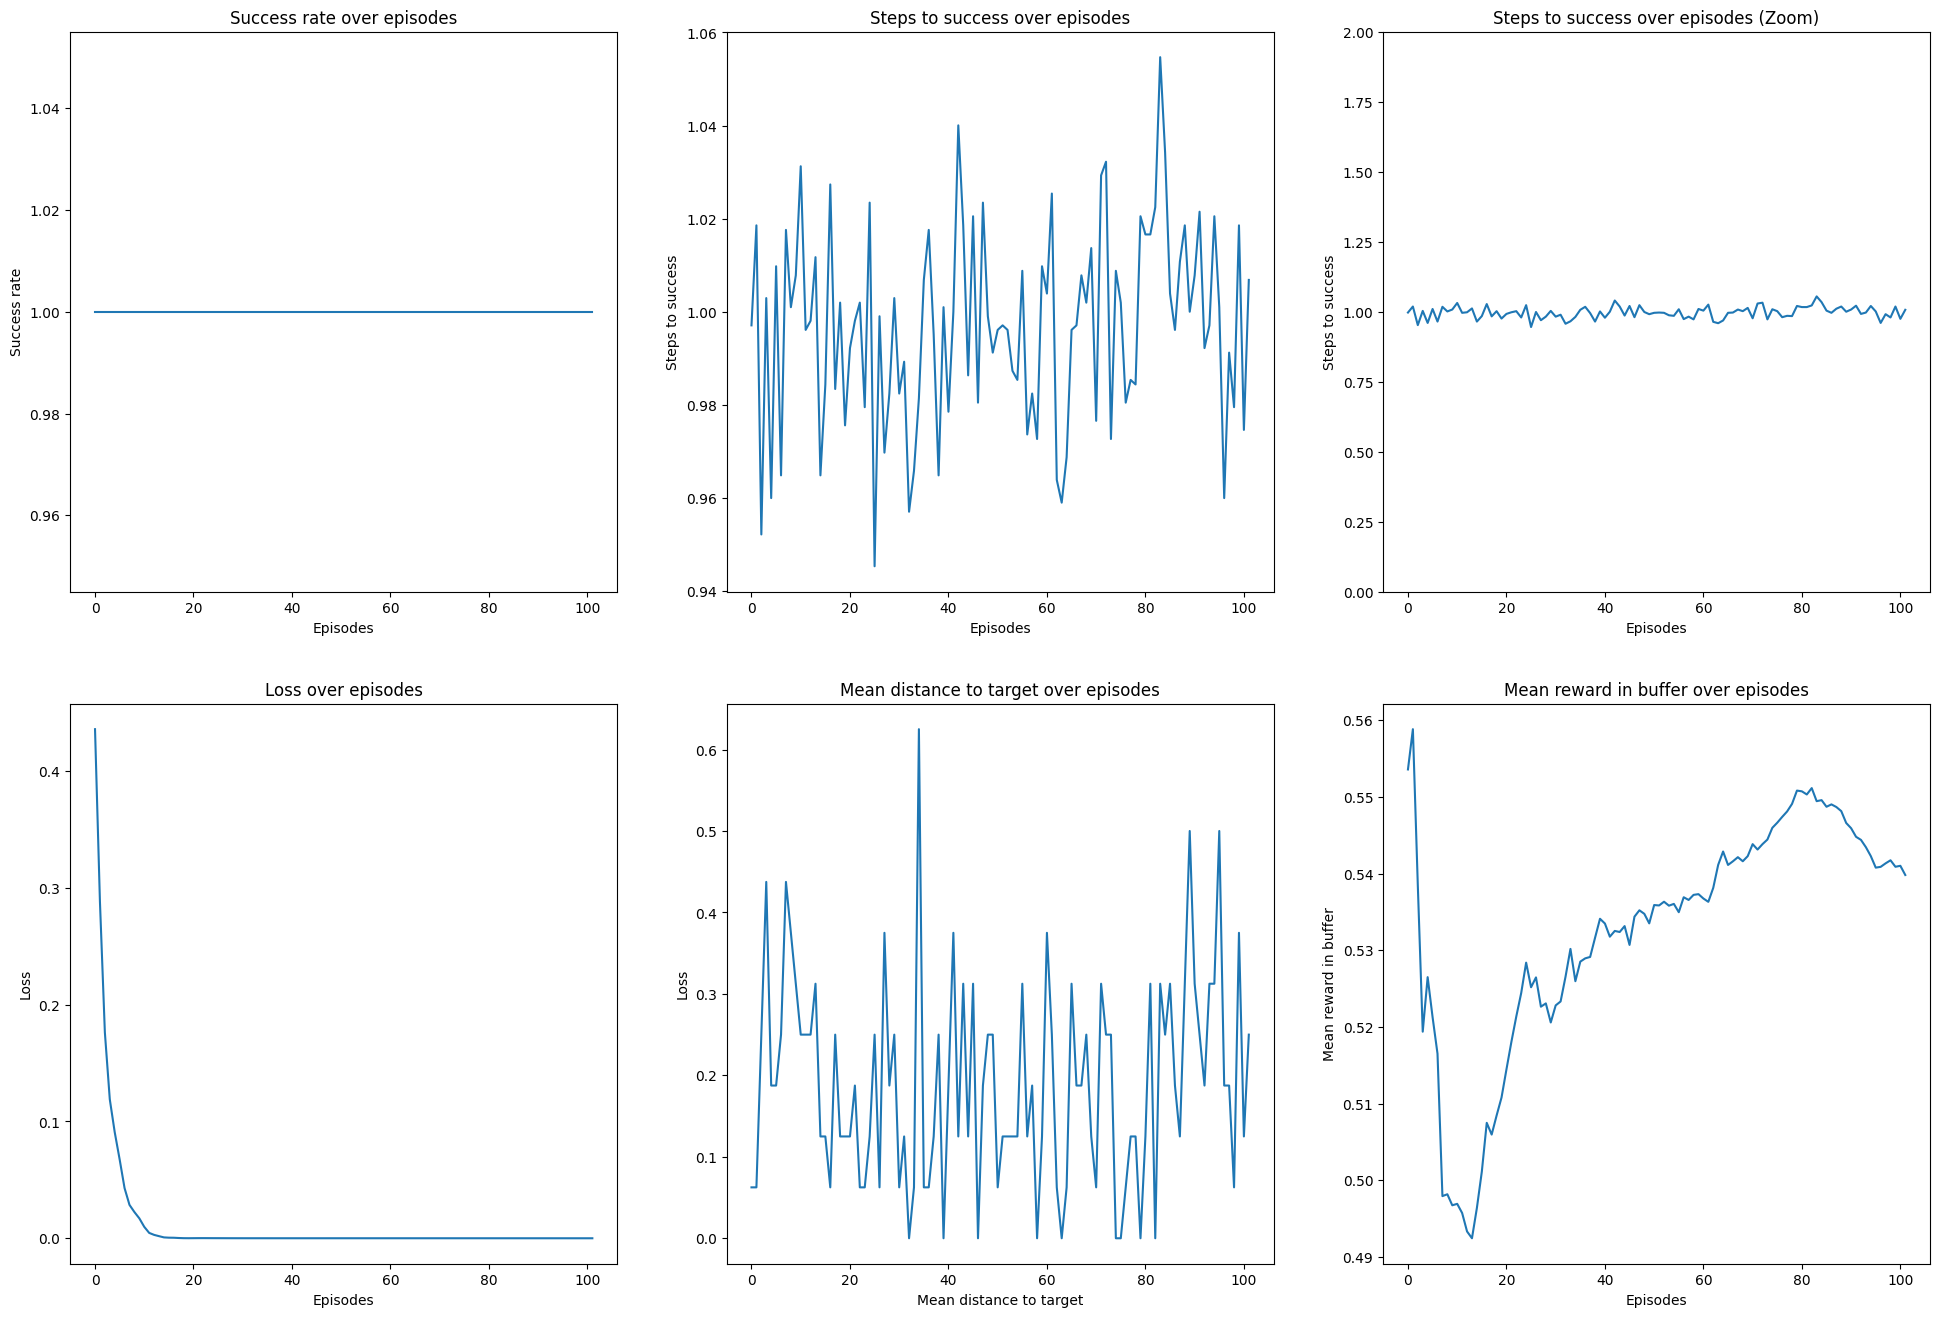

(<src.environments.env_bit_sequence_flipping_goals.FlippingBitSequenceEnvWithGoals at 0x7c3e89557760>,
 <src.agents.agent_dqn_her.DQNHERAgent at 0x7c3e89556ad0>)

In [2]:
train_DQN_HER_agent(2, device=device)

$n=3$, optimal agent achieved as steps $\sim \frac{3}{2}$

Initialized FlippingBitSequenceEnvWithGoals with n = 3. Randomly picked target: tensor([0, 1, 0], device='cuda:1')
Initial distance to target: 1
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  1%|          | 102/10000 [00:03<05:18, 31.04it/s]


Early stopping at episode 102
Episode: 102/10000, Epsilon: 0.5388547601058953, Success rate: 1.00, Avg steps to success: 1.48, Loss: 0.000011


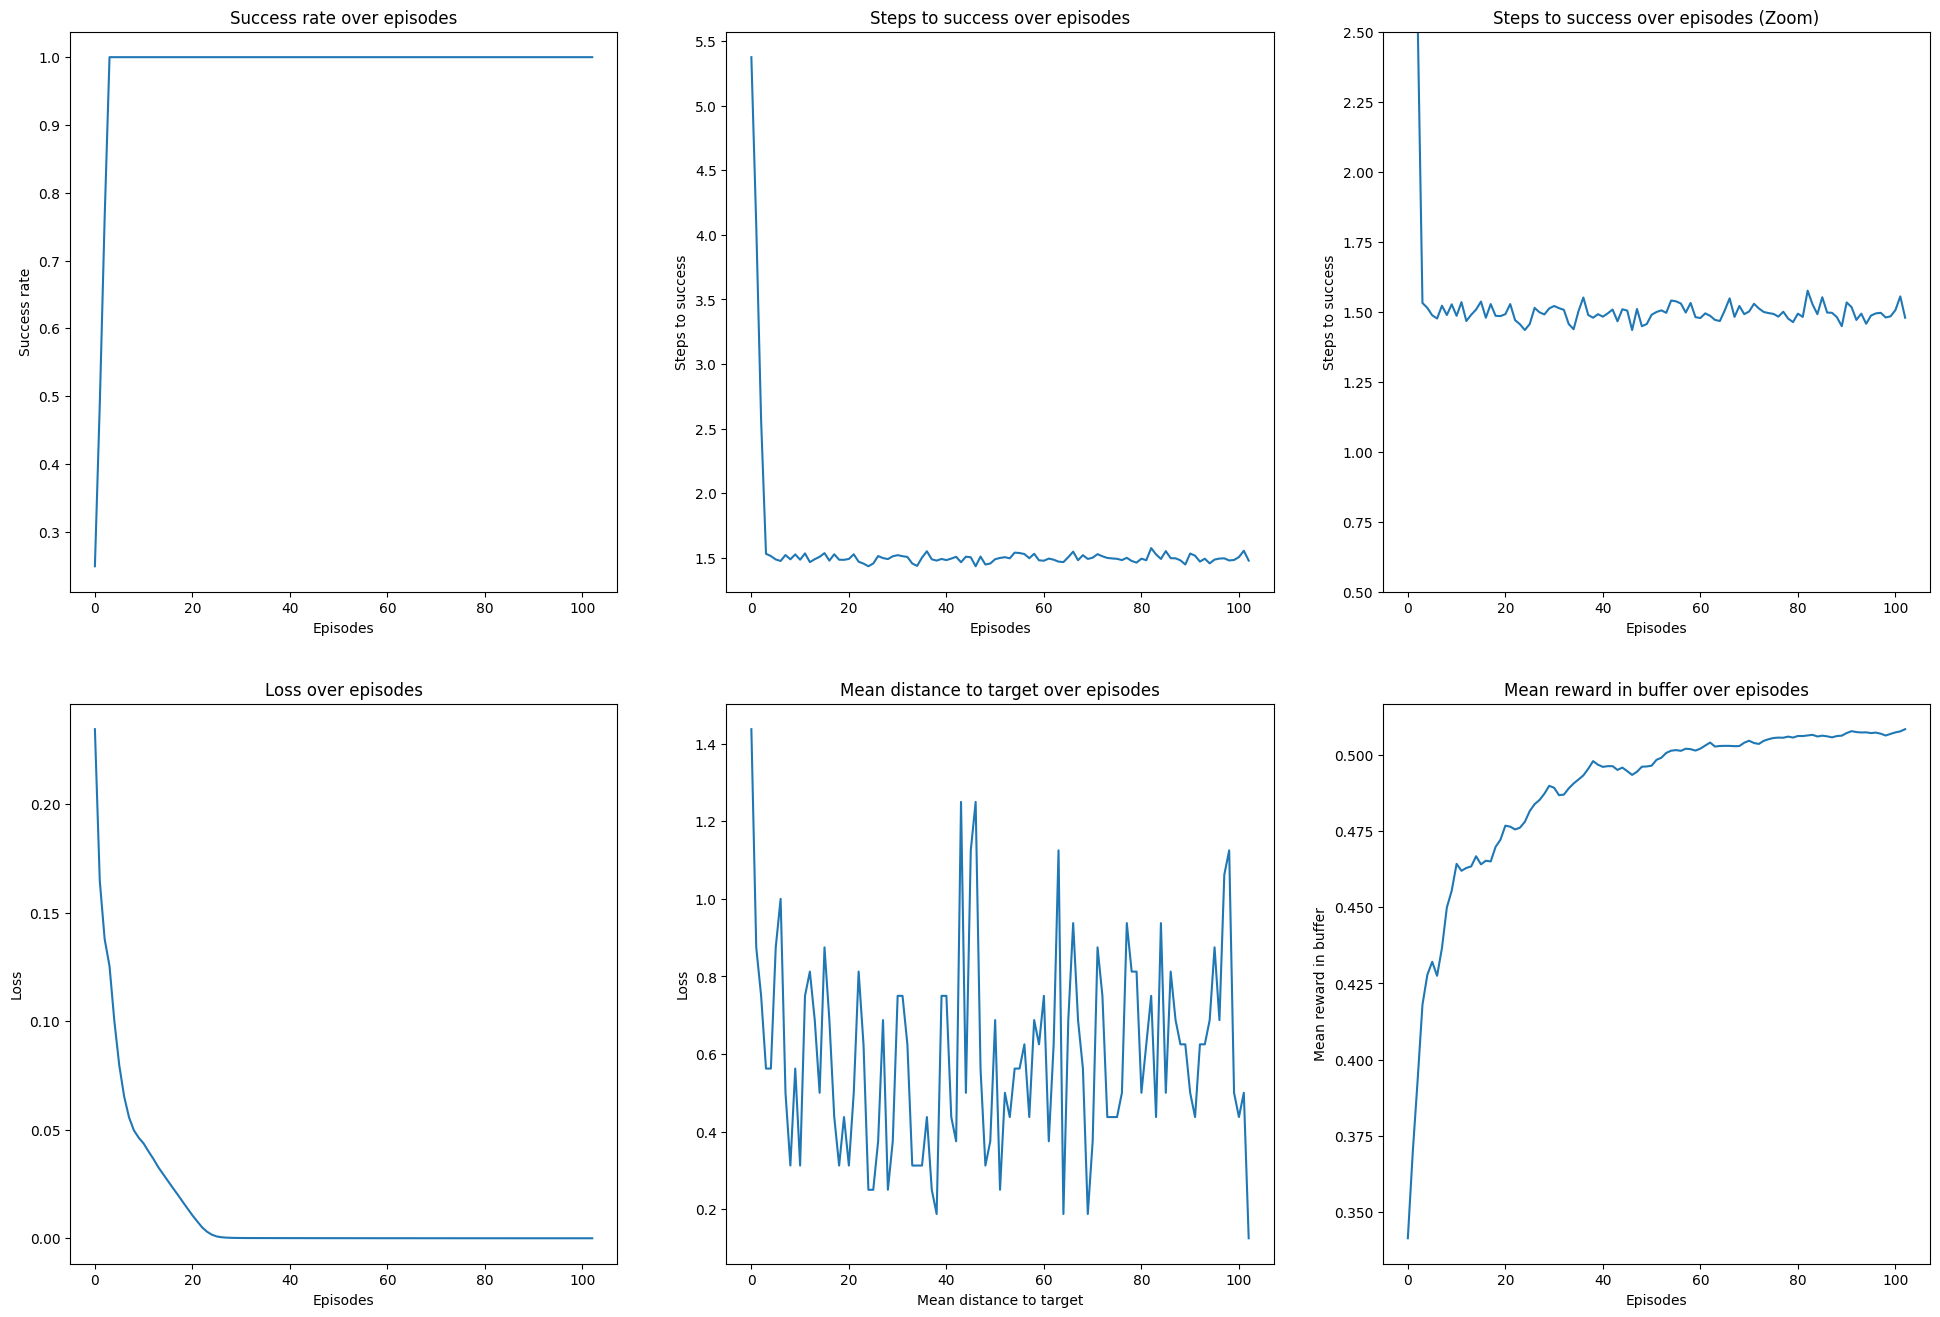

(<src.environments.env_bit_sequence_flipping_goals.FlippingBitSequenceEnvWithGoals at 0x7c3e5ee10fd0>,
 <src.agents.agent_dqn_her.DQNHERAgent at 0x7c3e89557bb0>)

In [3]:
train_DQN_HER_agent(3, device=device)

$n=6$, optimal agent achieved as steps $\sim 3$

Initialized FlippingBitSequenceEnvWithGoals with n = 6. Randomly picked target: tensor([1, 0, 0, 0, 0, 0], device='cuda:1')
Initial distance to target: 3
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  2%|▏         | 204/10000 [00:09<06:21, 25.71it/s]

Episode: 199/10000, Epsilon: 0.09060908449456685, Success rate: 0.20, Avg steps to success: 10.97, Loss: 0.000025


  4%|▍         | 402/10000 [00:17<07:00, 22.81it/s]

Episode: 399/10000, Epsilon: 0.05, Success rate: 0.02, Avg steps to success: 12.72, Loss: 0.000373


  6%|▌         | 603/10000 [00:26<06:13, 25.17it/s]

Episode: 599/10000, Epsilon: 0.05, Success rate: 0.25, Avg steps to success: 10.29, Loss: 0.000749


  8%|▊         | 804/10000 [00:34<06:12, 24.71it/s]

Episode: 799/10000, Epsilon: 0.05, Success rate: 0.17, Avg steps to success: 11.27, Loss: 0.000208


 10%|█         | 1002/10000 [00:42<06:18, 23.79it/s]

Episode: 999/10000, Epsilon: 0.05, Success rate: 0.02, Avg steps to success: 12.77, Loss: 0.000049


 12%|█▏        | 1203/10000 [00:51<06:20, 23.14it/s]

Episode: 1199/10000, Epsilon: 0.05, Success rate: 0.19, Avg steps to success: 11.04, Loss: 0.000012


 14%|█▍        | 1404/10000 [00:59<05:53, 24.32it/s]

Episode: 1399/10000, Epsilon: 0.05, Success rate: 0.62, Avg steps to success: 7.12, Loss: 0.000151


 16%|█▌        | 1602/10000 [01:07<05:37, 24.87it/s]

Episode: 1599/10000, Epsilon: 0.05, Success rate: 0.10, Avg steps to success: 11.86, Loss: 0.000042


 18%|█▊        | 1803/10000 [01:15<05:47, 23.59it/s]

Episode: 1799/10000, Epsilon: 0.05, Success rate: 0.12, Avg steps to success: 11.68, Loss: 0.000182


 20%|██        | 2004/10000 [01:24<05:40, 23.49it/s]

Episode: 1999/10000, Epsilon: 0.05, Success rate: 0.16, Avg steps to success: 11.19, Loss: 0.000356


 22%|██▏       | 2202/10000 [01:33<05:39, 22.99it/s]

Episode: 2199/10000, Epsilon: 0.05, Success rate: 0.17, Avg steps to success: 11.15, Loss: 0.000050


 24%|██▍       | 2403/10000 [01:41<05:24, 23.45it/s]

Episode: 2399/10000, Epsilon: 0.05, Success rate: 0.01, Avg steps to success: 12.87, Loss: 0.000042


 26%|██▌       | 2604/10000 [01:50<04:48, 25.64it/s]

Episode: 2599/10000, Epsilon: 0.05, Success rate: 0.43, Avg steps to success: 8.63, Loss: 0.000083


 28%|██▊       | 2802/10000 [01:58<04:54, 24.45it/s]

Episode: 2799/10000, Epsilon: 0.05, Success rate: 0.02, Avg steps to success: 12.69, Loss: 0.000020


 30%|███       | 3003/10000 [02:06<04:36, 25.27it/s]

Episode: 2999/10000, Epsilon: 0.05, Success rate: 0.18, Avg steps to success: 10.97, Loss: 0.000733


 32%|███▏      | 3204/10000 [02:14<04:41, 24.18it/s]

Episode: 3199/10000, Epsilon: 0.05, Success rate: 0.13, Avg steps to success: 11.61, Loss: 0.000021


 34%|███▍      | 3402/10000 [02:23<04:26, 24.75it/s]

Episode: 3399/10000, Epsilon: 0.05, Success rate: 0.09, Avg steps to success: 11.90, Loss: 0.000009


 36%|███▌      | 3603/10000 [02:31<04:19, 24.67it/s]

Episode: 3599/10000, Epsilon: 0.05, Success rate: 0.06, Avg steps to success: 12.33, Loss: 0.000052


 38%|███▊      | 3804/10000 [02:39<04:21, 23.67it/s]

Episode: 3799/10000, Epsilon: 0.05, Success rate: 0.10, Avg steps to success: 11.91, Loss: 0.000059


 40%|████      | 4002/10000 [02:48<04:10, 23.99it/s]

Episode: 3999/10000, Epsilon: 0.05, Success rate: 0.04, Avg steps to success: 12.54, Loss: 0.000173


 42%|████▏     | 4203/10000 [02:56<03:57, 24.45it/s]

Episode: 4199/10000, Epsilon: 0.05, Success rate: 0.39, Avg steps to success: 8.92, Loss: 0.000199


 44%|████▍     | 4404/10000 [03:04<04:06, 22.66it/s]

Episode: 4399/10000, Epsilon: 0.05, Success rate: 0.37, Avg steps to success: 9.05, Loss: 0.000065


 46%|████▌     | 4605/10000 [03:13<03:35, 25.05it/s]

Episode: 4599/10000, Epsilon: 0.05, Success rate: 0.02, Avg steps to success: 12.78, Loss: 0.000129


 48%|████▊     | 4803/10000 [03:21<03:44, 23.18it/s]

Episode: 4799/10000, Epsilon: 0.05, Success rate: 0.02, Avg steps to success: 12.76, Loss: 0.000002


 50%|█████     | 5004/10000 [03:29<03:16, 25.38it/s]

Episode: 4999/10000, Epsilon: 0.05, Success rate: 0.38, Avg steps to success: 9.18, Loss: 0.000029


 52%|█████▏    | 5205/10000 [03:38<03:12, 24.95it/s]

Episode: 5199/10000, Epsilon: 0.05, Success rate: 0.21, Avg steps to success: 10.78, Loss: 0.000073


 54%|█████▍    | 5403/10000 [03:46<03:30, 21.88it/s]

Episode: 5399/10000, Epsilon: 0.05, Success rate: 0.70, Avg steps to success: 5.97, Loss: 0.000051


 56%|█████▌    | 5604/10000 [03:54<03:02, 24.14it/s]

Episode: 5599/10000, Epsilon: 0.05, Success rate: 0.74, Avg steps to success: 5.44, Loss: 0.000015


 58%|█████▊    | 5803/10000 [04:03<03:42, 18.86it/s]

Episode: 5799/10000, Epsilon: 0.05, Success rate: 0.91, Avg steps to success: 4.06, Loss: 0.000047


 60%|██████    | 6004/10000 [04:12<02:51, 23.24it/s]

Episode: 5999/10000, Epsilon: 0.05, Success rate: 0.36, Avg steps to success: 9.13, Loss: 0.000016


 62%|██████▏   | 6202/10000 [04:20<02:35, 24.36it/s]

Episode: 6199/10000, Epsilon: 0.05, Success rate: 0.20, Avg steps to success: 10.95, Loss: 0.000150


 64%|██████▍   | 6403/10000 [04:28<02:20, 25.59it/s]

Episode: 6399/10000, Epsilon: 0.05, Success rate: 0.16, Avg steps to success: 11.18, Loss: 0.000060


 66%|██████▌   | 6604/10000 [04:37<02:17, 24.75it/s]

Episode: 6599/10000, Epsilon: 0.05, Success rate: 0.20, Avg steps to success: 10.75, Loss: 0.000999


 68%|██████▊   | 6802/10000 [04:45<02:15, 23.55it/s]

Episode: 6799/10000, Epsilon: 0.05, Success rate: 0.07, Avg steps to success: 12.17, Loss: 0.000825


 70%|███████   | 7003/10000 [04:53<02:02, 24.45it/s]

Episode: 6999/10000, Epsilon: 0.05, Success rate: 0.22, Avg steps to success: 10.64, Loss: 0.000034


 72%|███████▏  | 7204/10000 [05:01<02:01, 23.07it/s]

Episode: 7199/10000, Epsilon: 0.05, Success rate: 0.02, Avg steps to success: 12.76, Loss: 0.000003


 74%|███████▍  | 7402/10000 [05:09<01:44, 24.75it/s]

Episode: 7399/10000, Epsilon: 0.05, Success rate: 0.13, Avg steps to success: 11.52, Loss: 0.000130


 76%|███████▌  | 7603/10000 [05:18<01:39, 24.12it/s]

Episode: 7599/10000, Epsilon: 0.05, Success rate: 0.08, Avg steps to success: 11.99, Loss: 0.000503


 78%|███████▊  | 7804/10000 [05:26<01:33, 23.37it/s]

Episode: 7799/10000, Epsilon: 0.05, Success rate: 0.40, Avg steps to success: 8.77, Loss: 0.000105


 80%|████████  | 8002/10000 [05:35<01:28, 22.58it/s]

Episode: 7999/10000, Epsilon: 0.05, Success rate: 0.13, Avg steps to success: 11.49, Loss: 0.000091


 82%|████████▏ | 8203/10000 [05:43<01:18, 22.87it/s]

Episode: 8199/10000, Epsilon: 0.05, Success rate: 0.53, Avg steps to success: 7.55, Loss: 0.000054


 84%|████████▍ | 8404/10000 [05:52<01:04, 24.60it/s]

Episode: 8399/10000, Epsilon: 0.05, Success rate: 0.02, Avg steps to success: 12.70, Loss: 0.000048


 86%|████████▌ | 8605/10000 [06:00<00:54, 25.45it/s]

Episode: 8599/10000, Epsilon: 0.05, Success rate: 0.17, Avg steps to success: 11.17, Loss: 0.000008


 88%|████████▊ | 8803/10000 [06:09<00:53, 22.38it/s]

Episode: 8799/10000, Epsilon: 0.05, Success rate: 0.36, Avg steps to success: 9.30, Loss: 0.000137


 90%|█████████ | 9004/10000 [06:18<00:44, 22.60it/s]

Episode: 8999/10000, Epsilon: 0.05, Success rate: 0.39, Avg steps to success: 8.87, Loss: 0.000165


 92%|█████████▏| 9202/10000 [06:26<00:33, 24.10it/s]

Episode: 9199/10000, Epsilon: 0.05, Success rate: 0.32, Avg steps to success: 9.47, Loss: 0.000028


 94%|█████████▍| 9403/10000 [06:34<00:24, 24.40it/s]

Episode: 9399/10000, Epsilon: 0.05, Success rate: 0.69, Avg steps to success: 6.30, Loss: 0.000066


 96%|█████████▌| 9604/10000 [06:43<00:16, 24.17it/s]

Episode: 9599/10000, Epsilon: 0.05, Success rate: 0.63, Avg steps to success: 6.60, Loss: 0.000050


 98%|█████████▊| 9805/10000 [06:51<00:07, 24.92it/s]

Episode: 9799/10000, Epsilon: 0.05, Success rate: 0.17, Avg steps to success: 11.19, Loss: 0.000077


100%|██████████| 10000/10000 [06:59<00:00, 23.81it/s]


Episode: 9999/10000, Epsilon: 0.05, Success rate: 0.12, Avg steps to success: 11.71, Loss: 0.000164


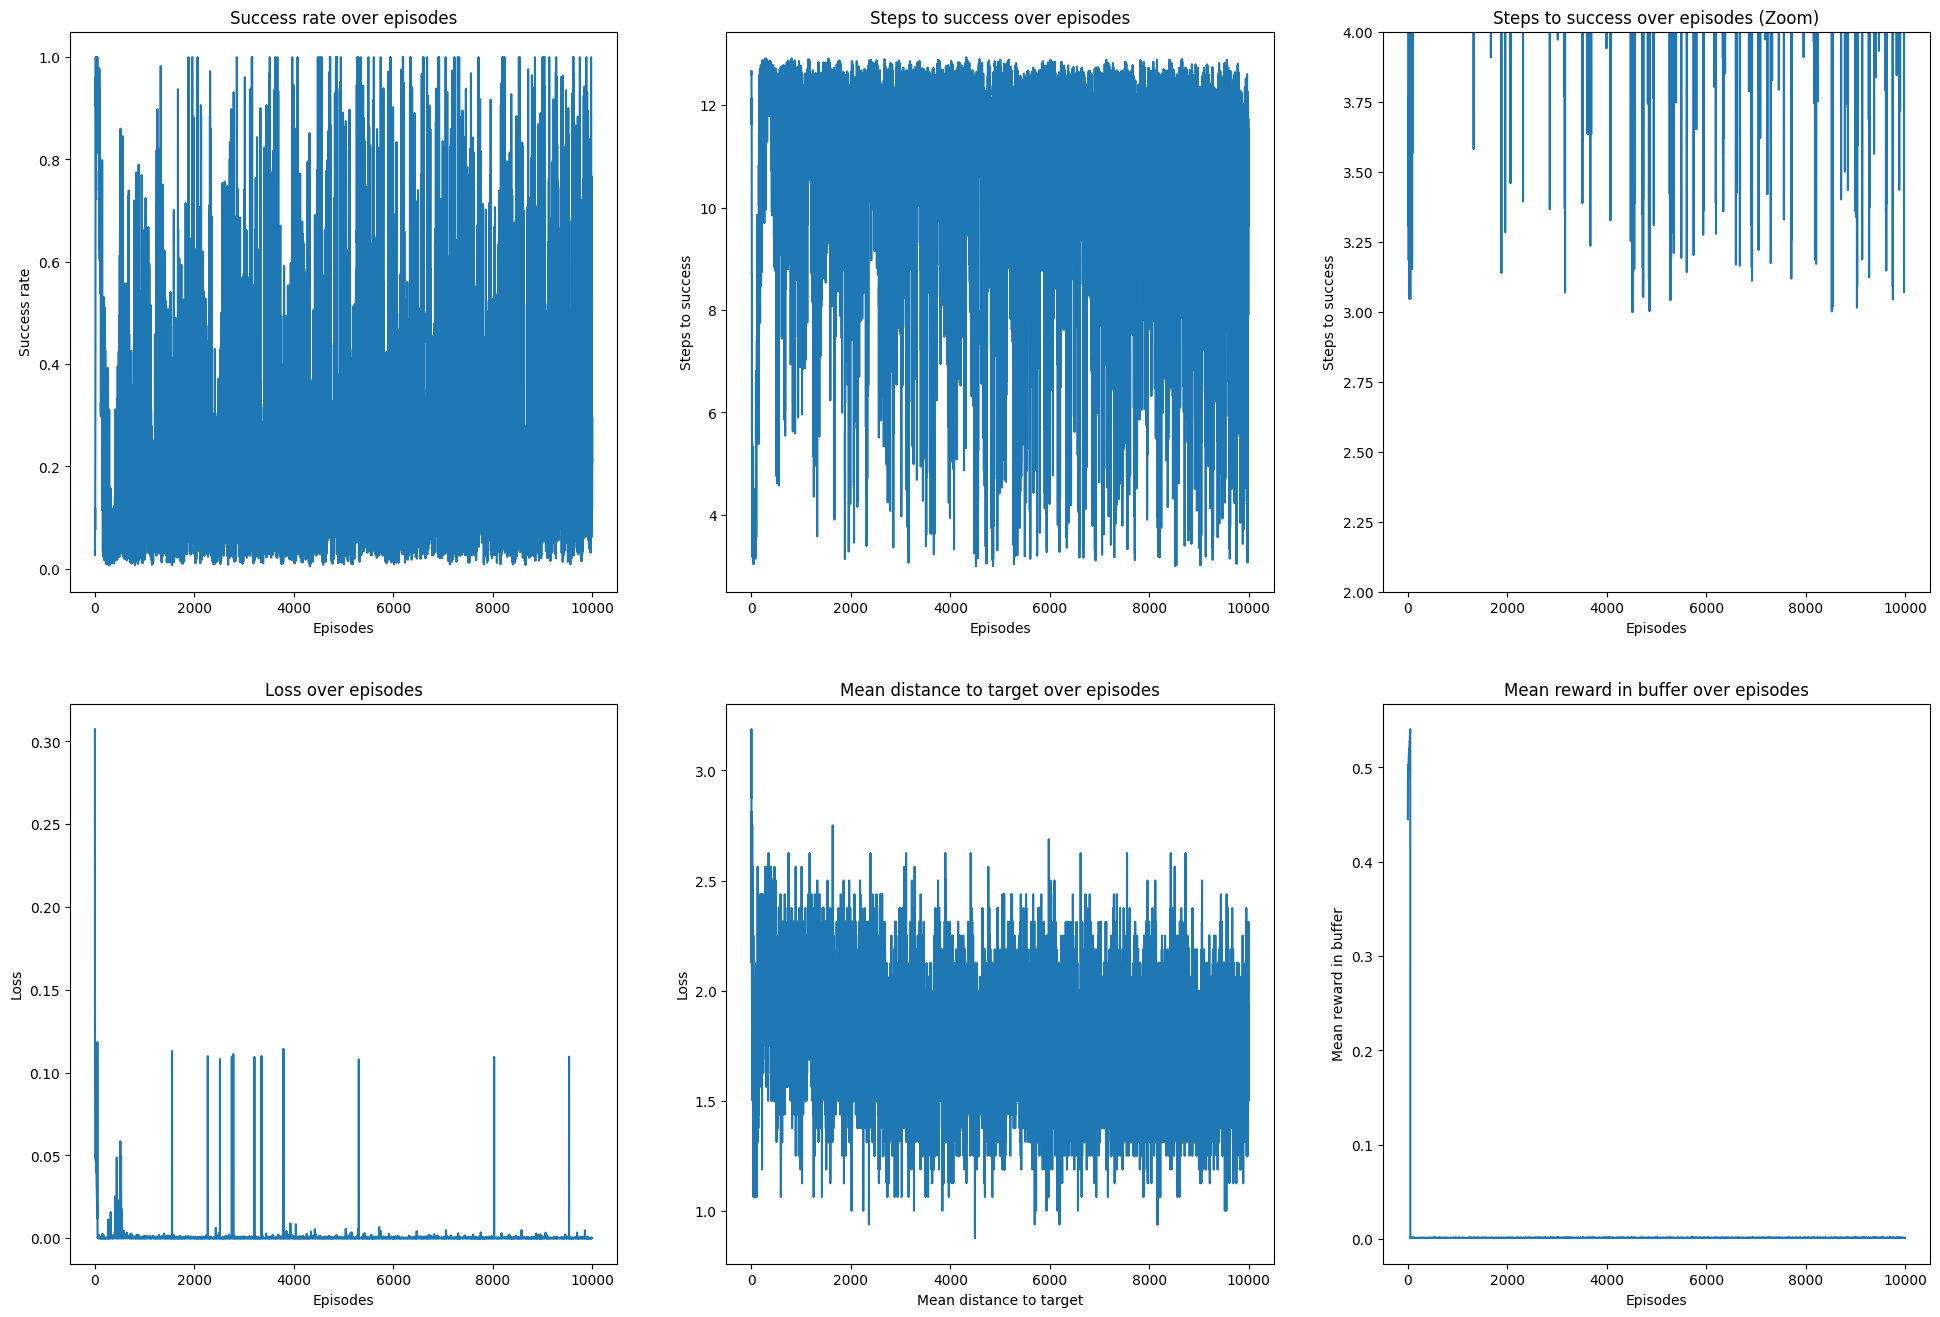

(<src.environments.env_bit_sequence_flipping_goals.FlippingBitSequenceEnvWithGoals at 0x7c3e614ec820>,
 <src.agents.agent_dqn_her.DQNHERAgent at 0x7c3e89557b50>)

In [4]:
train_DQN_HER_agent(6, device=device)

$n=15$, optimal agent achieved as steps $\sim 7.5$

Initialized FlippingBitSequenceEnvWithGoals with n = 9. Randomly picked target: tensor([1, 0, 1, 0, 0, 1, 1, 1, 0], device='cuda:1')
Initial distance to target: 6
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  2%|▏         | 202/10000 [00:13<09:34, 17.06it/s]

Episode: 199/10000, Epsilon: 0.05, Success rate: 0.05, Avg steps to success: 18.17, Loss: 0.000612


  4%|▍         | 402/10000 [00:24<08:45, 18.28it/s]

Episode: 399/10000, Epsilon: 0.05, Success rate: 0.03, Avg steps to success: 18.57, Loss: 0.000944


  6%|▌         | 602/10000 [00:36<09:44, 16.09it/s]

Episode: 599/10000, Epsilon: 0.05, Success rate: 0.01, Avg steps to success: 18.88, Loss: 0.000128


  8%|▊         | 802/10000 [00:49<09:26, 16.23it/s]

Episode: 799/10000, Epsilon: 0.05, Success rate: 0.02, Avg steps to success: 18.67, Loss: 0.000380


 10%|█         | 1002/10000 [01:01<09:23, 15.97it/s]

Episode: 999/10000, Epsilon: 0.05, Success rate: 0.02, Avg steps to success: 18.62, Loss: 0.002124


 12%|█▏        | 1202/10000 [01:13<09:02, 16.22it/s]

Episode: 1199/10000, Epsilon: 0.05, Success rate: 0.02, Avg steps to success: 18.66, Loss: 0.000123


 14%|█▍        | 1402/10000 [01:25<08:46, 16.32it/s]

Episode: 1399/10000, Epsilon: 0.05, Success rate: 0.01, Avg steps to success: 18.89, Loss: 0.037410


 16%|█▌        | 1602/10000 [01:37<08:46, 15.95it/s]

Episode: 1599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 18.98, Loss: 0.000310


 18%|█▊        | 1802/10000 [01:49<08:30, 16.07it/s]

Episode: 1799/10000, Epsilon: 0.05, Success rate: 0.08, Avg steps to success: 17.85, Loss: 0.000043


 20%|██        | 2002/10000 [02:01<08:21, 15.94it/s]

Episode: 1999/10000, Epsilon: 0.05, Success rate: 0.01, Avg steps to success: 18.88, Loss: 0.000525


 22%|██▏       | 2202/10000 [02:13<07:24, 17.52it/s]

Episode: 2199/10000, Epsilon: 0.05, Success rate: 0.01, Avg steps to success: 18.86, Loss: 0.000149


 24%|██▍       | 2402/10000 [02:25<07:25, 17.07it/s]

Episode: 2399/10000, Epsilon: 0.05, Success rate: 0.01, Avg steps to success: 18.82, Loss: 0.000092


 26%|██▌       | 2602/10000 [02:36<06:53, 17.91it/s]

Episode: 2599/10000, Epsilon: 0.05, Success rate: 0.02, Avg steps to success: 18.69, Loss: 0.000440


 28%|██▊       | 2802/10000 [02:48<07:35, 15.79it/s]

Episode: 2799/10000, Epsilon: 0.05, Success rate: 0.01, Avg steps to success: 18.79, Loss: 0.001028


 30%|███       | 3002/10000 [03:00<06:32, 17.81it/s]

Episode: 2999/10000, Epsilon: 0.05, Success rate: 0.01, Avg steps to success: 18.88, Loss: 0.000904


 32%|███▏      | 3202/10000 [03:12<06:48, 16.65it/s]

Episode: 3199/10000, Epsilon: 0.05, Success rate: 0.02, Avg steps to success: 18.74, Loss: 0.000205


 34%|███▍      | 3402/10000 [03:24<06:11, 17.76it/s]

Episode: 3399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 18.98, Loss: 0.007849


 36%|███▌      | 3602/10000 [03:35<06:15, 17.04it/s]

Episode: 3599/10000, Epsilon: 0.05, Success rate: 0.18, Avg steps to success: 16.33, Loss: 0.000484


 38%|███▊      | 3802/10000 [03:47<05:55, 17.41it/s]

Episode: 3799/10000, Epsilon: 0.05, Success rate: 0.07, Avg steps to success: 17.94, Loss: 0.121366


 40%|████      | 4002/10000 [03:59<06:14, 16.02it/s]

Episode: 3999/10000, Epsilon: 0.05, Success rate: 0.07, Avg steps to success: 17.96, Loss: 0.000032


 42%|████▏     | 4202/10000 [04:11<05:20, 18.07it/s]

Episode: 4199/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 19.00, Loss: 0.001061


 44%|████▍     | 4402/10000 [04:23<05:17, 17.64it/s]

Episode: 4399/10000, Epsilon: 0.05, Success rate: 0.05, Avg steps to success: 18.20, Loss: 0.000119


 46%|████▌     | 4602/10000 [04:35<05:16, 17.06it/s]

Episode: 4599/10000, Epsilon: 0.05, Success rate: 0.01, Avg steps to success: 18.84, Loss: 0.000051


 48%|████▊     | 4802/10000 [04:46<05:07, 16.91it/s]

Episode: 4799/10000, Epsilon: 0.05, Success rate: 0.02, Avg steps to success: 18.67, Loss: 0.000090


 50%|█████     | 5002/10000 [04:58<04:51, 17.12it/s]

Episode: 4999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 18.95, Loss: 0.000159


 52%|█████▏    | 5202/10000 [05:09<04:34, 17.47it/s]

Episode: 5199/10000, Epsilon: 0.05, Success rate: 0.05, Avg steps to success: 18.20, Loss: 0.000065


 54%|█████▍    | 5402/10000 [05:21<04:36, 16.66it/s]

Episode: 5399/10000, Epsilon: 0.05, Success rate: 0.01, Avg steps to success: 18.86, Loss: 0.000227


 56%|█████▌    | 5602/10000 [05:33<04:30, 16.27it/s]

Episode: 5599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 18.91, Loss: 0.000438


 58%|█████▊    | 5802/10000 [05:46<04:08, 16.89it/s]

Episode: 5799/10000, Epsilon: 0.05, Success rate: 0.14, Avg steps to success: 16.92, Loss: 0.000176


 60%|██████    | 6002/10000 [05:58<04:09, 16.05it/s]

Episode: 5999/10000, Epsilon: 0.05, Success rate: 0.01, Avg steps to success: 18.88, Loss: 0.000478


 62%|██████▏   | 6202/10000 [06:10<03:58, 15.95it/s]

Episode: 6199/10000, Epsilon: 0.05, Success rate: 0.04, Avg steps to success: 18.38, Loss: 0.000262


 64%|██████▍   | 6402/10000 [06:23<03:46, 15.87it/s]

Episode: 6399/10000, Epsilon: 0.05, Success rate: 0.13, Avg steps to success: 16.93, Loss: 0.000025


 66%|██████▌   | 6602/10000 [06:34<03:10, 17.82it/s]

Episode: 6599/10000, Epsilon: 0.05, Success rate: 0.04, Avg steps to success: 18.44, Loss: 0.000042


 68%|██████▊   | 6802/10000 [06:46<02:58, 17.93it/s]

Episode: 6799/10000, Epsilon: 0.05, Success rate: 0.04, Avg steps to success: 18.38, Loss: 0.000038


 70%|███████   | 7002/10000 [06:58<02:50, 17.56it/s]

Episode: 6999/10000, Epsilon: 0.05, Success rate: 0.11, Avg steps to success: 17.36, Loss: 0.000173


 72%|███████▏  | 7202/10000 [07:11<03:02, 15.29it/s]

Episode: 7199/10000, Epsilon: 0.05, Success rate: 0.16, Avg steps to success: 16.63, Loss: 0.000382


 74%|███████▍  | 7402/10000 [07:24<02:51, 15.12it/s]

Episode: 7399/10000, Epsilon: 0.05, Success rate: 0.04, Avg steps to success: 18.43, Loss: 0.000134


 76%|███████▌  | 7602/10000 [07:36<02:31, 15.84it/s]

Episode: 7599/10000, Epsilon: 0.05, Success rate: 0.03, Avg steps to success: 18.49, Loss: 0.000119


 78%|███████▊  | 7802/10000 [07:48<02:16, 16.05it/s]

Episode: 7799/10000, Epsilon: 0.05, Success rate: 0.03, Avg steps to success: 18.51, Loss: 0.000306


 80%|████████  | 8002/10000 [08:01<02:04, 16.10it/s]

Episode: 7999/10000, Epsilon: 0.05, Success rate: 0.07, Avg steps to success: 17.87, Loss: 0.000077


 82%|████████▏ | 8202/10000 [08:13<01:51, 16.18it/s]

Episode: 8199/10000, Epsilon: 0.05, Success rate: 0.01, Avg steps to success: 18.81, Loss: 0.000116


 84%|████████▍ | 8402/10000 [08:25<01:39, 16.01it/s]

Episode: 8399/10000, Epsilon: 0.05, Success rate: 0.12, Avg steps to success: 17.16, Loss: 0.000510


 86%|████████▌ | 8602/10000 [08:37<01:23, 16.69it/s]

Episode: 8599/10000, Epsilon: 0.05, Success rate: 0.01, Avg steps to success: 18.81, Loss: 0.000122


 88%|████████▊ | 8802/10000 [08:50<01:14, 16.06it/s]

Episode: 8799/10000, Epsilon: 0.05, Success rate: 0.01, Avg steps to success: 18.84, Loss: 0.000111


 90%|█████████ | 9002/10000 [09:02<01:01, 16.35it/s]

Episode: 8999/10000, Epsilon: 0.05, Success rate: 0.08, Avg steps to success: 17.71, Loss: 0.000398


 92%|█████████▏| 9202/10000 [09:13<00:45, 17.42it/s]

Episode: 9199/10000, Epsilon: 0.05, Success rate: 0.17, Avg steps to success: 16.31, Loss: 0.000229


 94%|█████████▍| 9402/10000 [09:25<00:36, 16.56it/s]

Episode: 9399/10000, Epsilon: 0.05, Success rate: 0.05, Avg steps to success: 18.13, Loss: 0.000060


 96%|█████████▌| 9602/10000 [09:37<00:27, 14.42it/s]

Episode: 9599/10000, Epsilon: 0.05, Success rate: 0.08, Avg steps to success: 17.84, Loss: 0.000297


 98%|█████████▊| 9802/10000 [09:50<00:10, 18.05it/s]

Episode: 9799/10000, Epsilon: 0.05, Success rate: 0.03, Avg steps to success: 18.54, Loss: 0.000050


100%|██████████| 10000/10000 [10:01<00:00, 16.62it/s]


Episode: 9999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 18.96, Loss: 0.000069


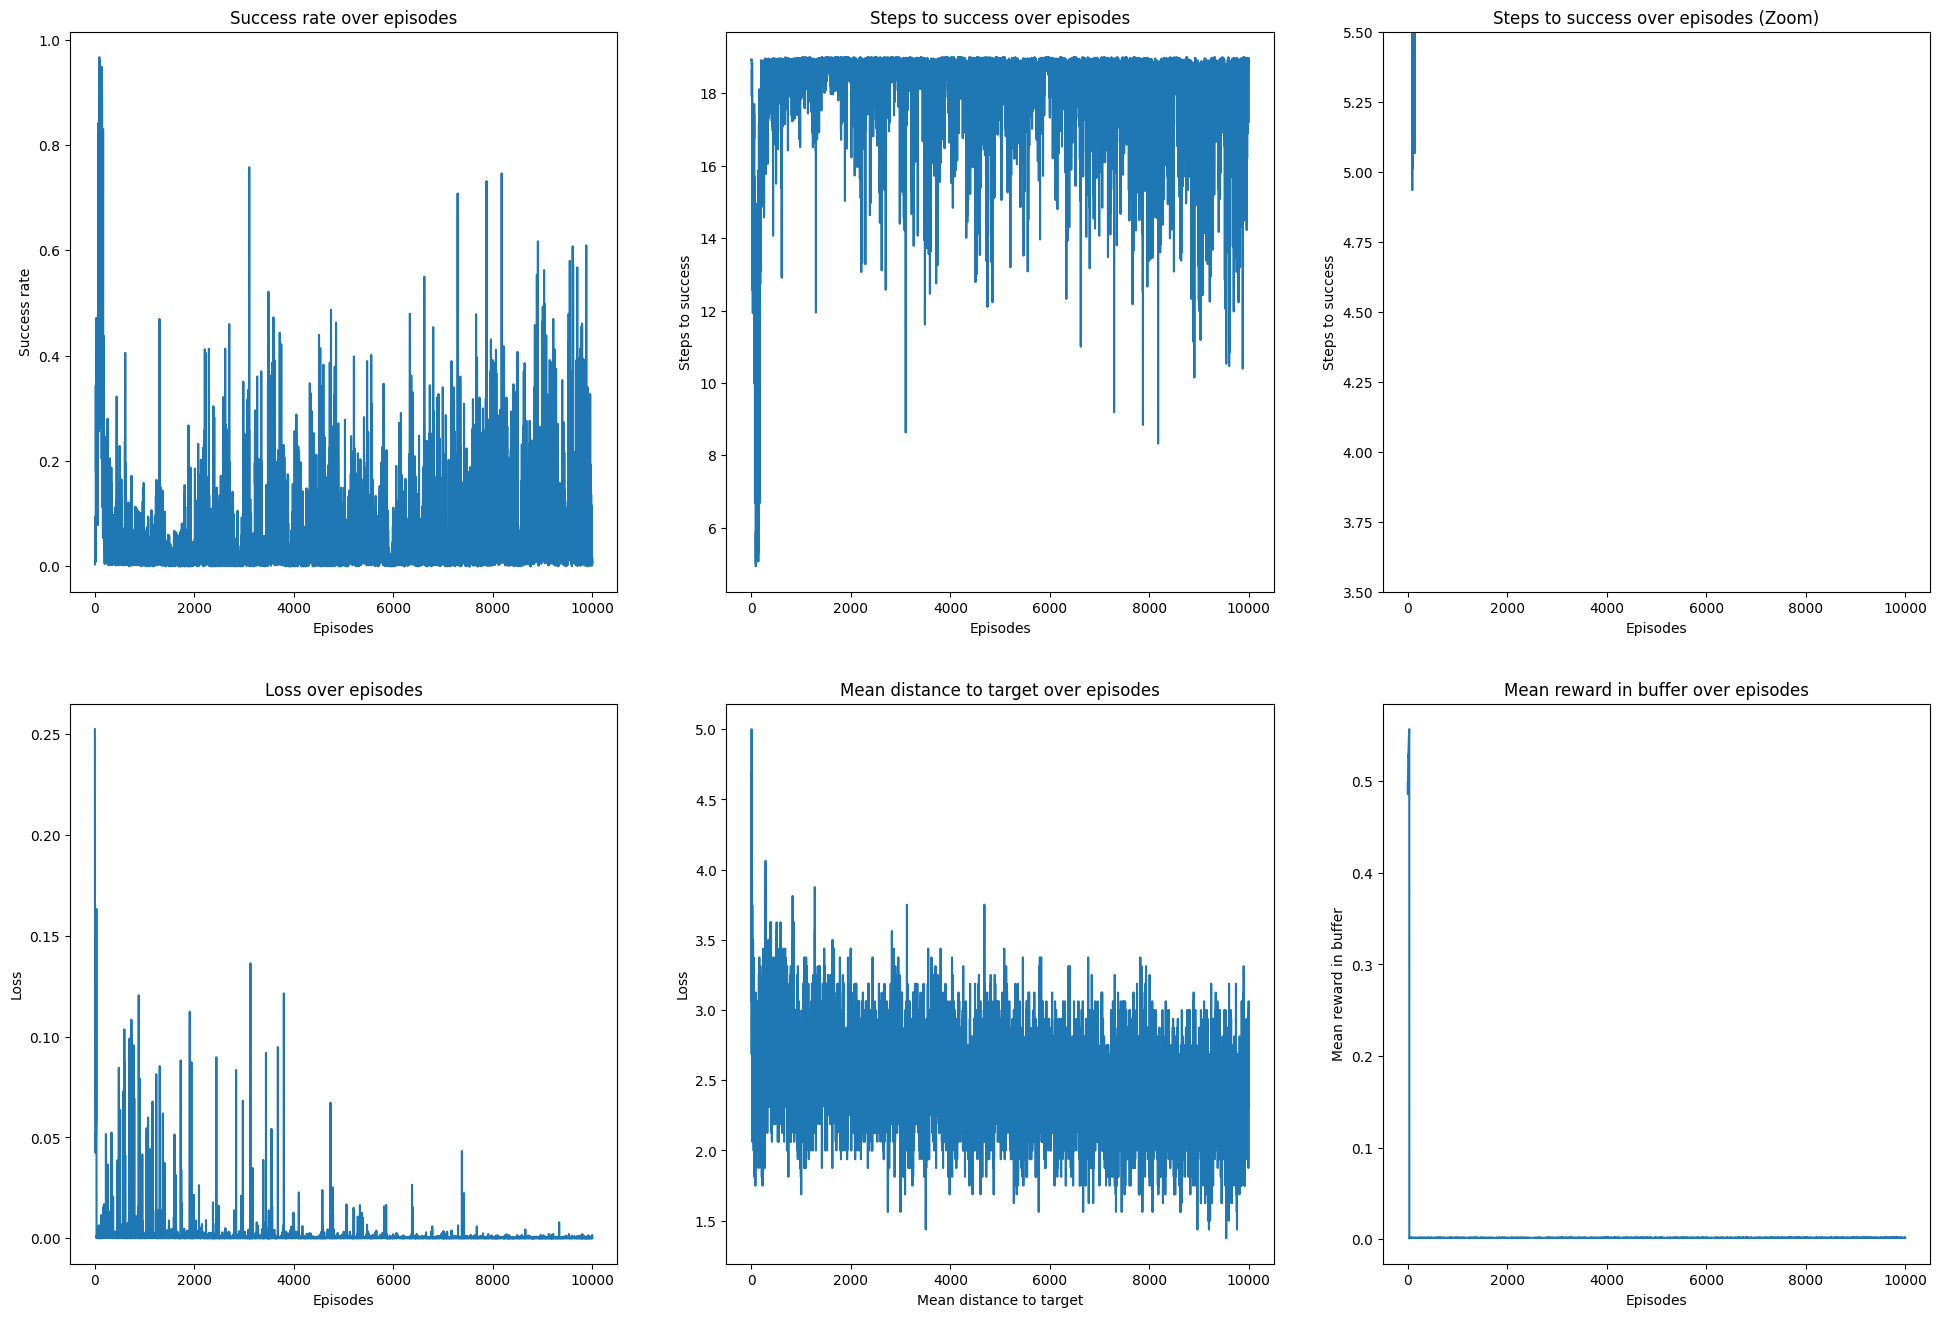

In [5]:
env, agent = train_DQN_HER_agent(9, device=device, num_goals=30)

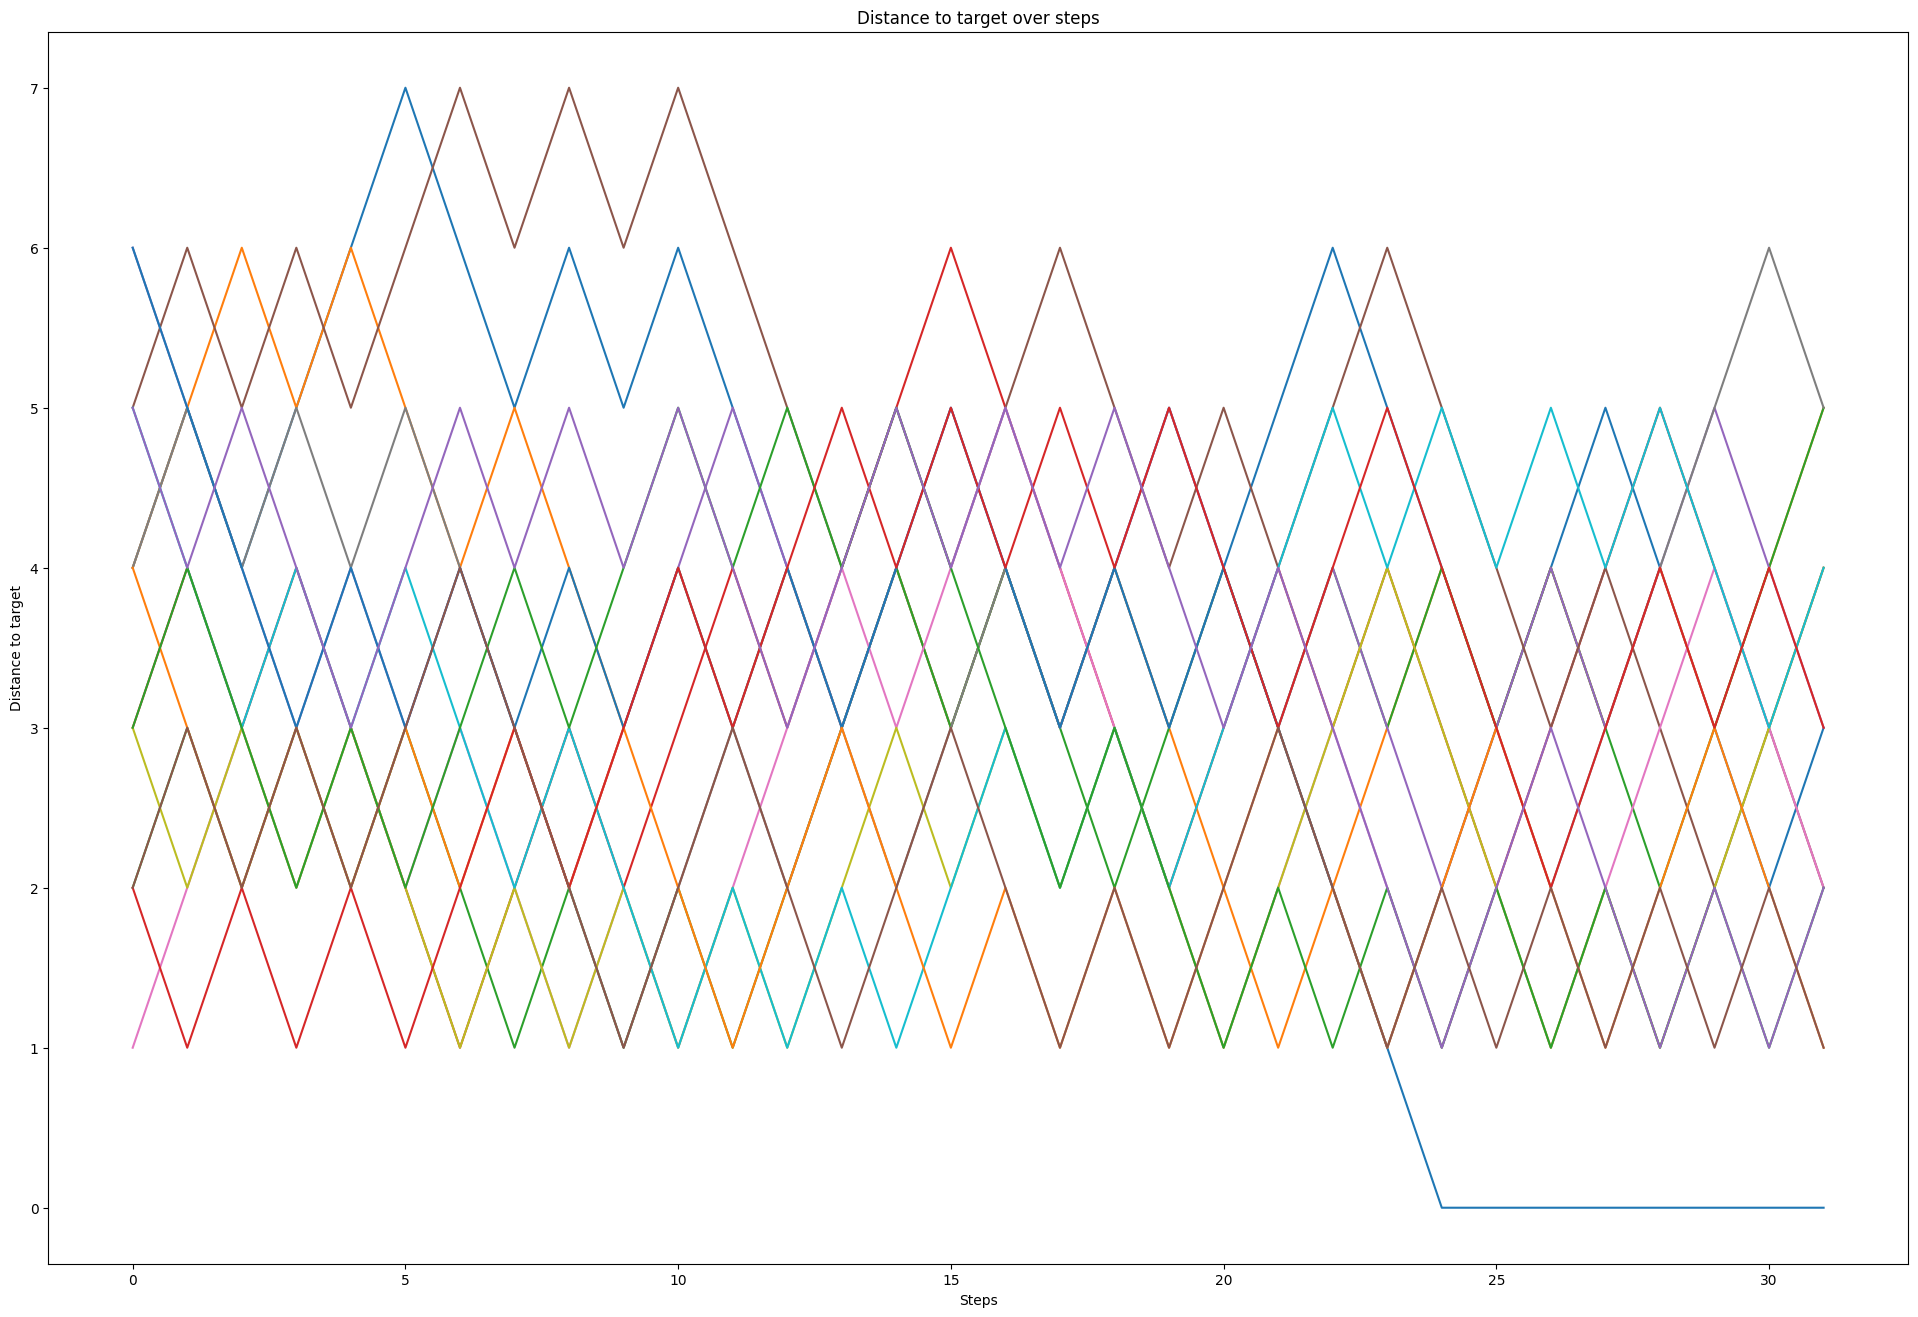

In [6]:
visualize_agent_trajectory(env, agent, 9, explore=True, explore_mode="logits_temperature", num_agents=16, goal=0, steps=2 * 16)

$n=15$. Given more training epochs, an optimal agent could be found (avg steps 7.5)

Initialized FlippingBitSequenceEnvWithGoals with n = 15. Randomly picked target: tensor([1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1], device='cuda:1')
Initial distance to target: 5
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  5%|▌         | 202/4000 [00:19<05:59, 10.57it/s]

Episode: 199/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000355


 10%|█         | 401/4000 [00:38<06:05,  9.85it/s]

Episode: 399/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000606


 15%|█▌        | 600/4000 [00:58<05:19, 10.65it/s]

Episode: 599/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000072


 20%|██        | 802/4000 [01:17<05:06, 10.44it/s]

Episode: 799/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000282


 25%|██▌       | 1001/4000 [01:36<04:42, 10.63it/s]

Episode: 999/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000256


 30%|███       | 1201/4000 [01:55<04:42,  9.91it/s]

Episode: 1199/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 30.97, Loss: 0.000377


 35%|███▌      | 1402/4000 [02:16<04:14, 10.20it/s]

Episode: 1399/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 30.97, Loss: 0.000533


 40%|████      | 1601/4000 [02:35<03:49, 10.43it/s]

Episode: 1599/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000370


 45%|████▌     | 1801/4000 [02:55<03:28, 10.57it/s]

Episode: 1799/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000281


 50%|█████     | 2001/4000 [03:14<03:08, 10.59it/s]

Episode: 1999/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000823


 55%|█████▌    | 2201/4000 [03:33<02:47, 10.75it/s]

Episode: 2199/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000098


 60%|██████    | 2402/4000 [03:52<02:30, 10.63it/s]

Episode: 2399/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 30.97, Loss: 0.000413


 65%|██████▌   | 2601/4000 [04:11<02:19, 10.00it/s]

Episode: 2599/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000283


 70%|███████   | 2801/4000 [04:31<01:56, 10.33it/s]

Episode: 2799/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000270


 75%|███████▌  | 3001/4000 [04:50<01:32, 10.83it/s]

Episode: 2999/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000296


 80%|████████  | 3201/4000 [05:09<01:14, 10.70it/s]

Episode: 3199/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000337


 85%|████████▌ | 3402/4000 [05:29<01:00,  9.92it/s]

Episode: 3399/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000417


 90%|█████████ | 3601/4000 [05:48<00:38, 10.39it/s]

Episode: 3599/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000131


 95%|█████████▌| 3801/4000 [06:06<00:17, 11.22it/s]

Episode: 3799/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000293


100%|██████████| 4000/4000 [06:25<00:00, 10.37it/s]


Episode: 3999/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000092


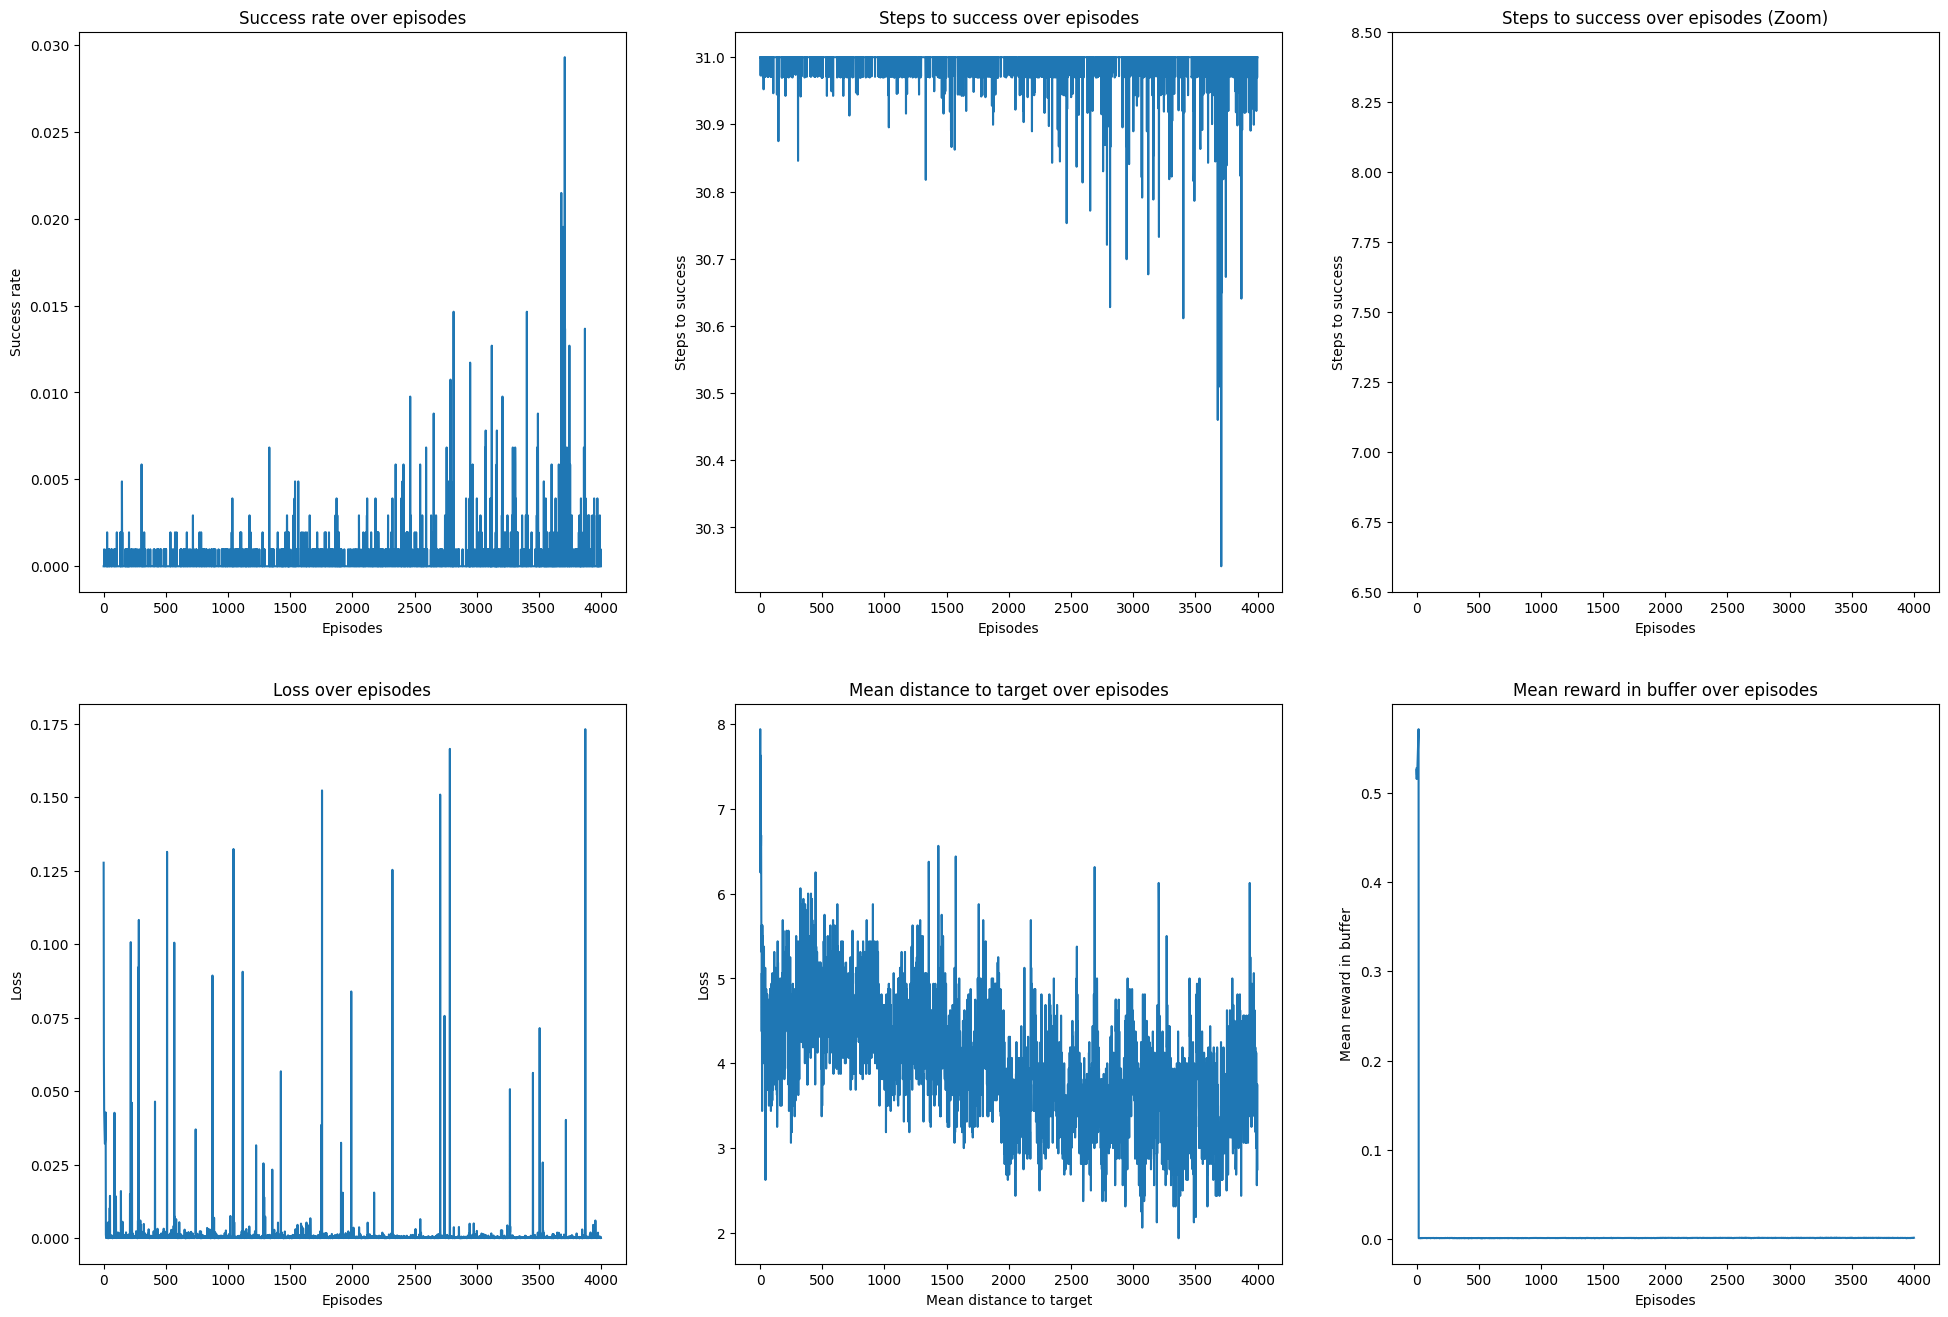

In [7]:
env, agent = train_DQN_HER_agent(15, device=device, episodes=4000)

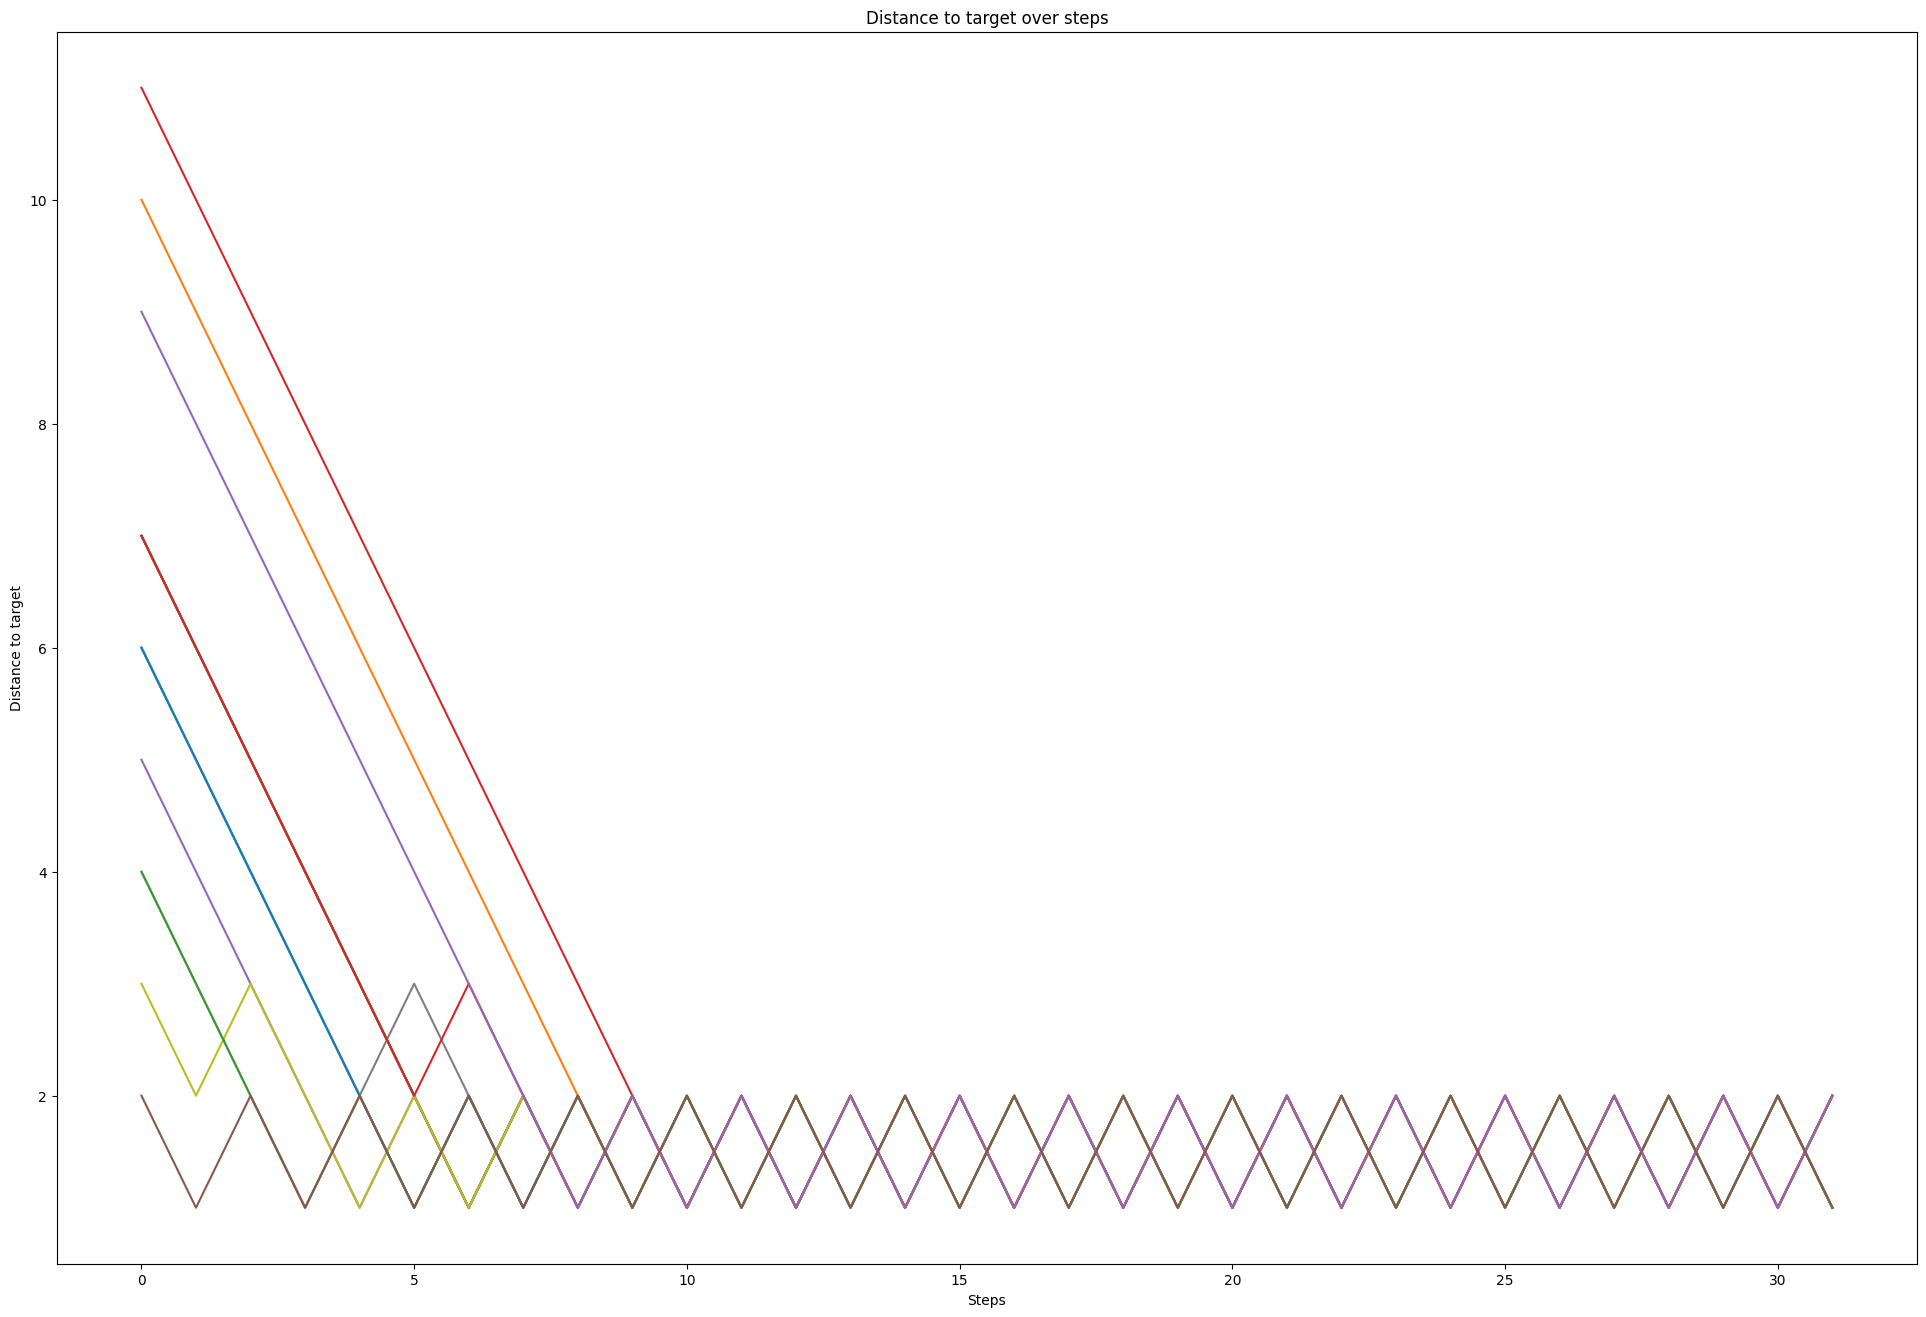

'with torch.no_grad():\n    x = agent.model(torch.tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device=device, dtype=torch.float32))[:, :, 6]\n    print(x)'

In [8]:
visualize_agent_trajectory(env, agent, 15, explore=False, explore_mode="logits_temperature", num_agents=16, goal=1, steps=2 * 16)
"""with torch.no_grad():
    x = agent.model(torch.tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device=device, dtype=torch.float32))[:, :, 6]
    print(x)"""

$n=30$ Now, with HER, our agent is able to find the optimal policy!

Initialized FlippingBitSequenceEnvWithGoals with n = 30. Randomly picked target: tensor([0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 0], device='cuda:1')
Initial distance to target: 15
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  2%|▏         | 200/10000 [00:45<35:57,  4.54it/s]

Episode: 199/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000549


  4%|▍         | 400/10000 [01:29<39:17,  4.07it/s]

Episode: 399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000662


  6%|▌         | 600/10000 [02:15<35:04,  4.47it/s]

Episode: 599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000766


  8%|▊         | 800/10000 [03:00<34:46,  4.41it/s]

Episode: 799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000161


 10%|█         | 1000/10000 [03:47<35:08,  4.27it/s]

Episode: 999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000391


 12%|█▏        | 1200/10000 [04:32<35:23,  4.15it/s]

Episode: 1199/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000685


 14%|█▍        | 1400/10000 [05:17<32:59,  4.34it/s]

Episode: 1399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000041


 16%|█▌        | 1600/10000 [06:03<33:24,  4.19it/s]

Episode: 1599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000216


 18%|█▊        | 1800/10000 [06:50<32:51,  4.16it/s]

Episode: 1799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000107


 20%|██        | 2000/10000 [07:37<28:31,  4.67it/s]

Episode: 1999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000587


 22%|██▏       | 2200/10000 [08:23<32:45,  3.97it/s]

Episode: 2199/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000090


 24%|██▍       | 2400/10000 [09:07<29:18,  4.32it/s]

Episode: 2399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000166


 26%|██▌       | 2600/10000 [09:54<28:48,  4.28it/s]

Episode: 2599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000198


 28%|██▊       | 2800/10000 [10:41<26:18,  4.56it/s]

Episode: 2799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000120


 30%|███       | 3000/10000 [11:27<29:39,  3.93it/s]

Episode: 2999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000560


 32%|███▏      | 3200/10000 [12:13<26:37,  4.26it/s]

Episode: 3199/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000160


 34%|███▍      | 3400/10000 [13:01<24:14,  4.54it/s]

Episode: 3399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000101


 36%|███▌      | 3600/10000 [13:50<22:03,  4.83it/s]

Episode: 3599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000385


 38%|███▊      | 3800/10000 [14:34<22:33,  4.58it/s]

Episode: 3799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.001274


 40%|████      | 4000/10000 [15:19<22:44,  4.40it/s]

Episode: 3999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000274


 42%|████▏     | 4200/10000 [16:05<20:51,  4.63it/s]

Episode: 4199/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000324


 44%|████▍     | 4400/10000 [16:50<21:20,  4.37it/s]

Episode: 4399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000387


 46%|████▌     | 4600/10000 [17:37<18:31,  4.86it/s]

Episode: 4599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000256


 48%|████▊     | 4800/10000 [18:21<19:05,  4.54it/s]

Episode: 4799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000182


 50%|█████     | 5000/10000 [19:06<19:06,  4.36it/s]

Episode: 4999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000044


 52%|█████▏    | 5200/10000 [19:52<18:09,  4.40it/s]

Episode: 5199/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000566


 54%|█████▍    | 5400/10000 [20:37<16:21,  4.69it/s]

Episode: 5399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000267


 56%|█████▌    | 5600/10000 [21:23<18:00,  4.07it/s]

Episode: 5599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000379


 58%|█████▊    | 5800/10000 [22:08<17:05,  4.09it/s]

Episode: 5799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000174


 60%|██████    | 6000/10000 [22:53<14:38,  4.55it/s]

Episode: 5999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000193


 62%|██████▏   | 6200/10000 [23:40<16:33,  3.82it/s]

Episode: 6199/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000349


 64%|██████▍   | 6400/10000 [24:28<14:08,  4.24it/s]

Episode: 6399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000297


 66%|██████▌   | 6600/10000 [25:14<14:04,  4.03it/s]

Episode: 6599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000195


 68%|██████▊   | 6800/10000 [25:59<12:30,  4.26it/s]

Episode: 6799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000244


 70%|███████   | 7000/10000 [26:45<12:05,  4.13it/s]

Episode: 6999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000181


 72%|███████▏  | 7200/10000 [27:30<11:24,  4.09it/s]

Episode: 7199/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.001706


 74%|███████▍  | 7400/10000 [28:17<09:33,  4.53it/s]

Episode: 7399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000201


 76%|███████▌  | 7600/10000 [29:01<08:44,  4.58it/s]

Episode: 7599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000170


 78%|███████▊  | 7800/10000 [29:49<08:50,  4.15it/s]

Episode: 7799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.004619


 80%|████████  | 8000/10000 [30:35<07:08,  4.67it/s]

Episode: 7999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000223


 82%|████████▏ | 8200/10000 [31:23<06:06,  4.91it/s]

Episode: 8199/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.003667


 84%|████████▍ | 8400/10000 [32:08<05:41,  4.68it/s]

Episode: 8399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000570


 86%|████████▌ | 8600/10000 [32:53<05:28,  4.27it/s]

Episode: 8599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000785


 88%|████████▊ | 8800/10000 [33:39<04:47,  4.18it/s]

Episode: 8799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.001087


 90%|█████████ | 9000/10000 [34:25<03:43,  4.47it/s]

Episode: 8999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000078


 92%|█████████▏| 9200/10000 [35:10<03:07,  4.26it/s]

Episode: 9199/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000695


 94%|█████████▍| 9400/10000 [35:56<02:31,  3.97it/s]

Episode: 9399/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000340


 96%|█████████▌| 9600/10000 [36:42<01:26,  4.64it/s]

Episode: 9599/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000196


 98%|█████████▊| 9800/10000 [37:27<00:50,  3.98it/s]

Episode: 9799/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000134


100%|██████████| 10000/10000 [38:12<00:00,  4.36it/s]

Episode: 9999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000776


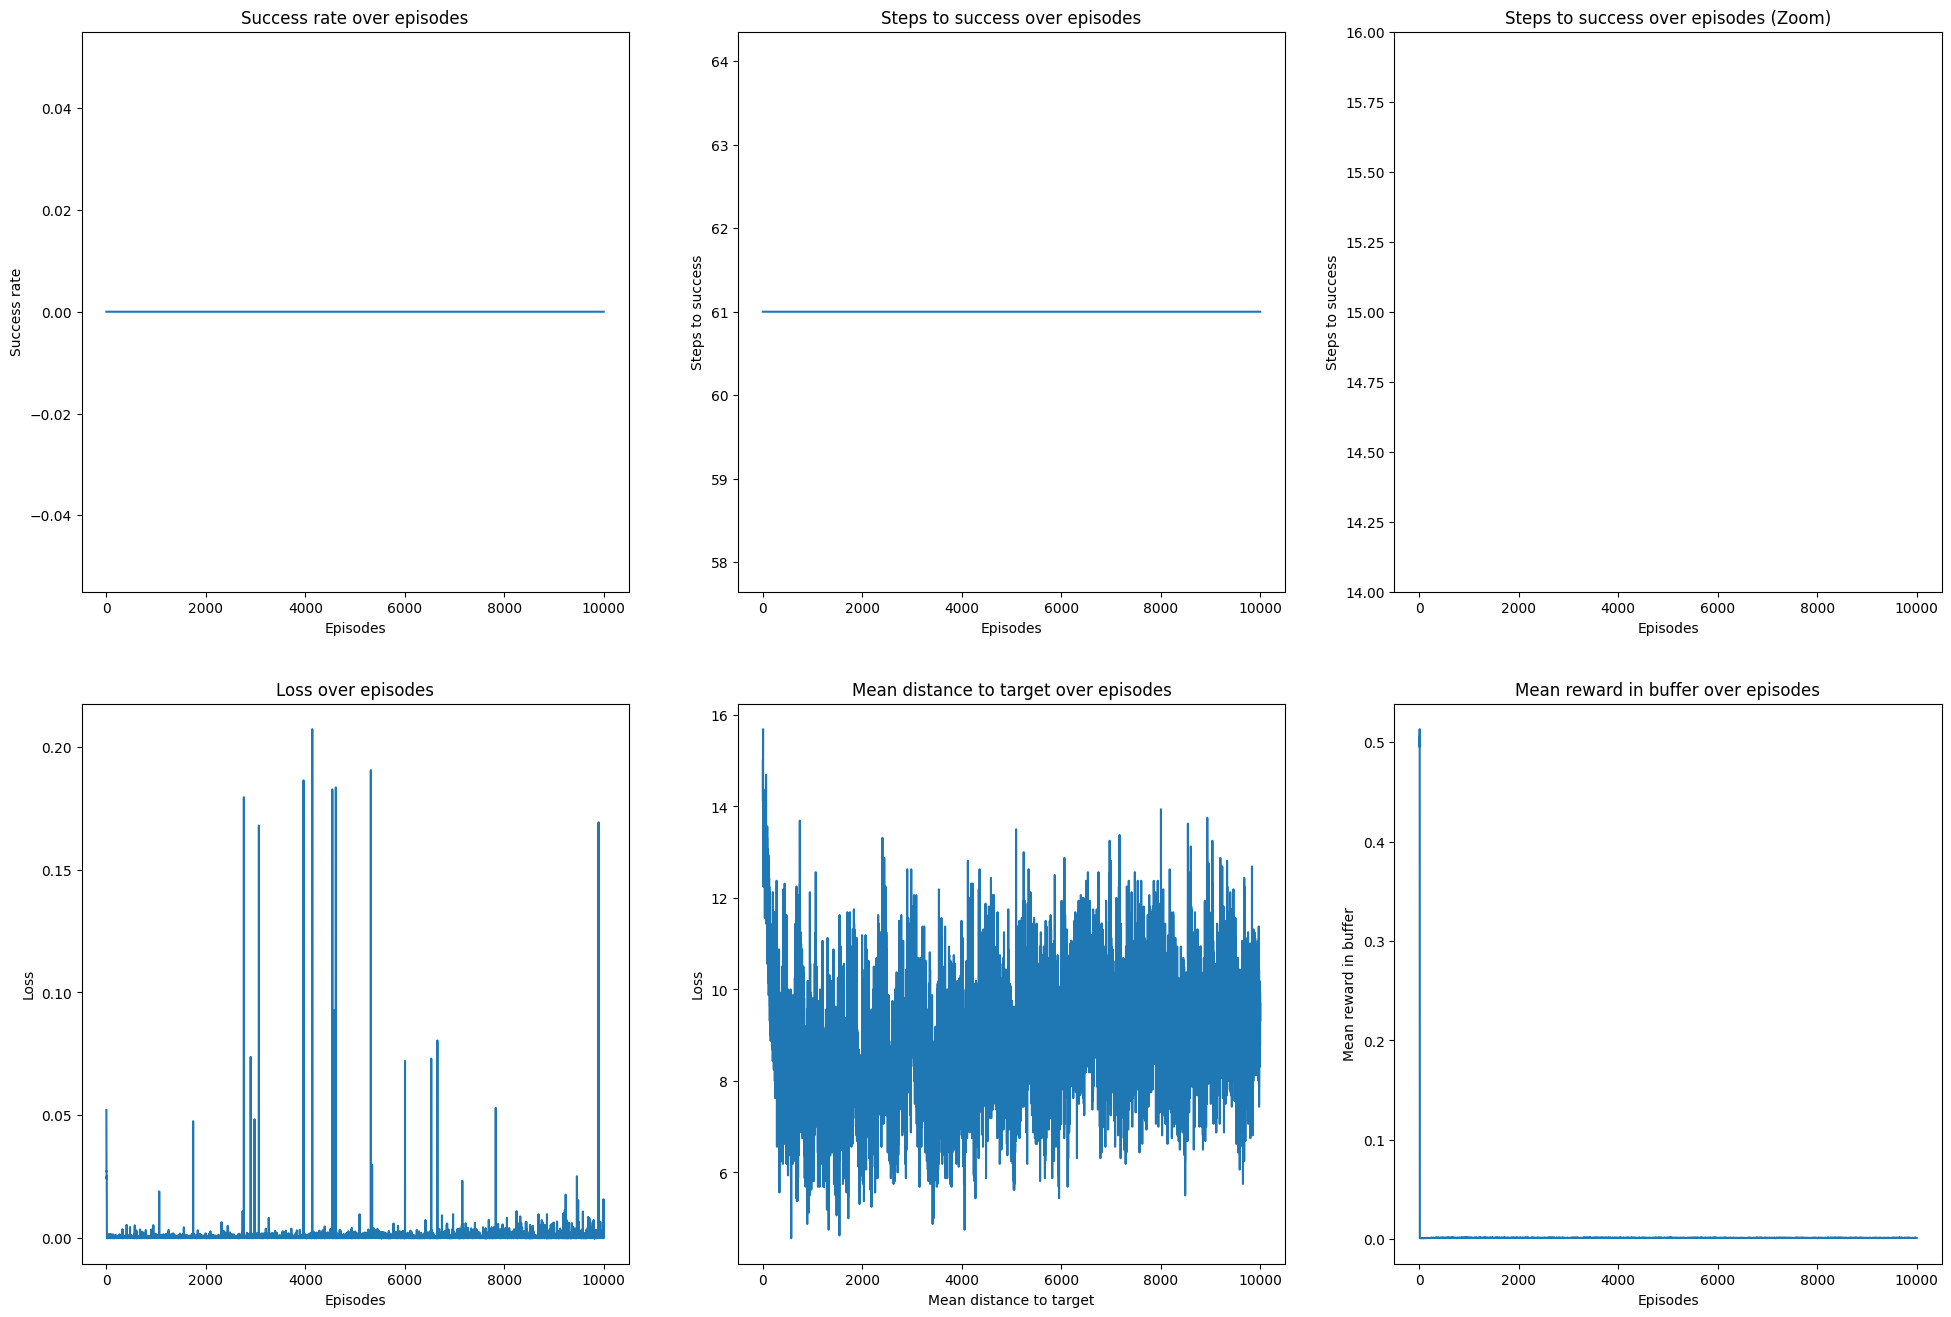

(<src.environments.env_bit_sequence_flipping_goals.FlippingBitSequenceEnvWithGoals at 0x7c3e614ec220>,
 <src.agents.agent_dqn_her.DQNHERAgent at 0x7c3e5ec537f0>)

In [9]:
train_DQN_HER_agent(30, device=device, episodes=10000)

$n=50$ Testing large $n$ with HER.

Initialized FlippingBitSequenceEnvWithGoals with n = 50. Randomly picked target: tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1], device='cuda:1')
Initial distance to target: 24
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


 20%|██        | 2000/10000 [13:31<52:50,  2.52it/s]  

Episode: 1999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 101.00, Loss: 0.000095


 40%|████      | 4000/10000 [27:01<42:48,  2.34it/s]

Episode: 3999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 101.00, Loss: 0.000294


 60%|██████    | 6000/10000 [40:37<26:53,  2.48it/s]

Episode: 5999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 101.00, Loss: 0.000422


 80%|████████  | 8000/10000 [54:10<14:49,  2.25it/s]

Episode: 7999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 101.00, Loss: 0.000358


100%|██████████| 10000/10000 [1:07:44<00:00,  2.46it/s]

Episode: 9999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 101.00, Loss: 0.000116


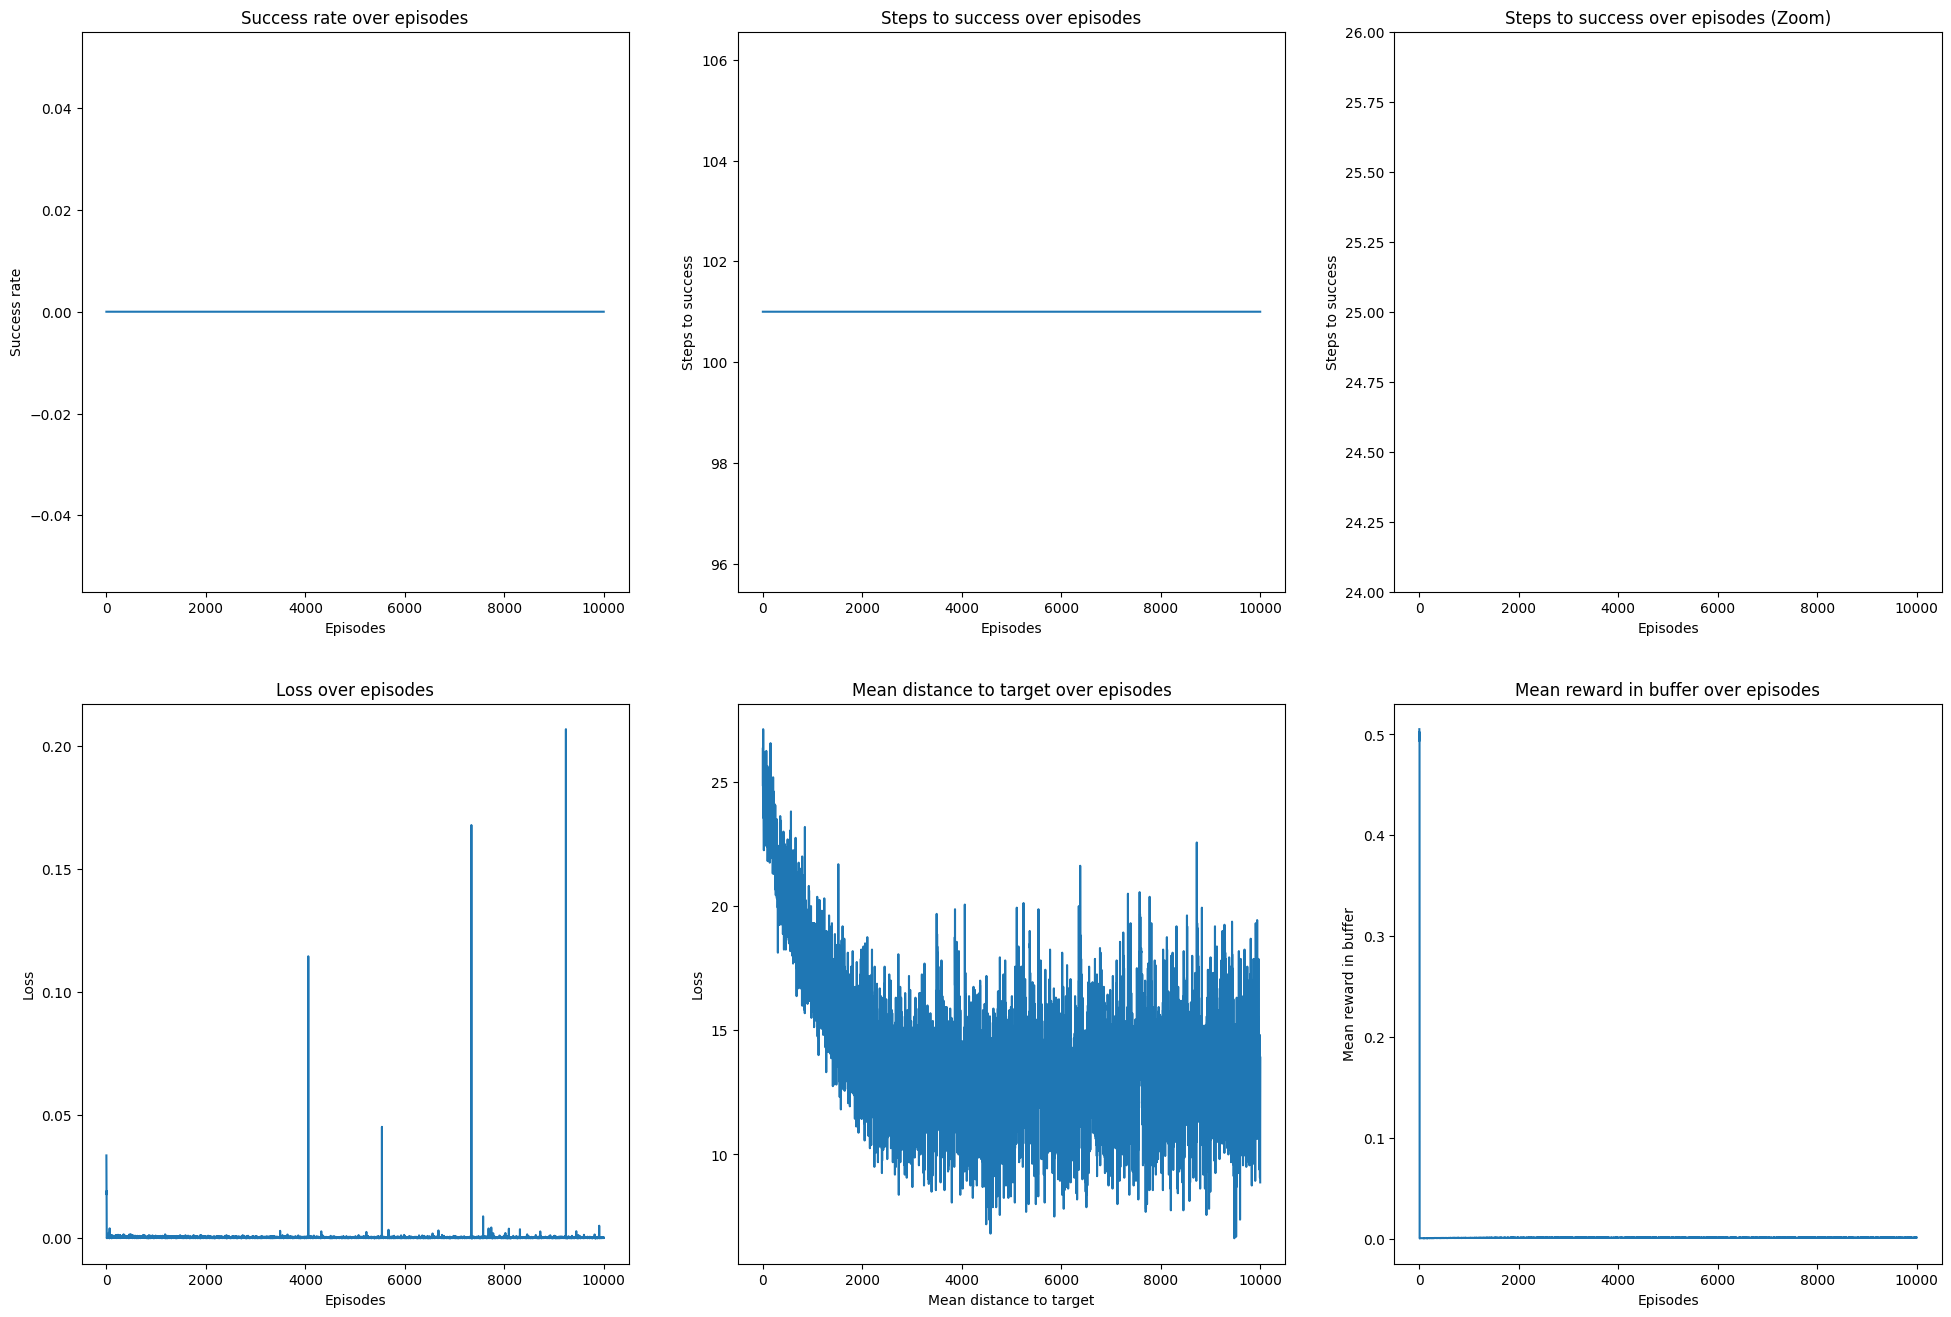

(<src.environments.env_bit_sequence_flipping_goals.FlippingBitSequenceEnvWithGoals at 0x7c3e614c8850>,
 <src.agents.agent_dqn_her.DQNHERAgent at 0x7c3e6145e230>)

In [10]:
train_DQN_HER_agent(50, device=device, episodes=10000, logging_frequency=2000)

# Experiements (DQN with goals, but no HER)

Here we only record the rewards of the goals where the exploration agent has acted with (meaning no HER). As mentioned before, this corresponds to $\text{num\_goals} = 1$

Initialized FlippingBitSequenceEnvWithGoals with n = 30. Randomly picked target: tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 1], device='cuda:1')
Initial distance to target: 17
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


 20%|██        | 2000/10000 [07:40<33:58,  3.92it/s]

Episode: 1999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000324


 40%|████      | 4000/10000 [15:18<22:47,  4.39it/s]

Episode: 3999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000663


 60%|██████    | 6000/10000 [22:57<14:45,  4.51it/s]

Episode: 5999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000189


 80%|████████  | 8000/10000 [30:32<07:11,  4.63it/s]

Episode: 7999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000644


100%|██████████| 10000/10000 [38:08<00:00,  4.37it/s]

Episode: 9999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000222


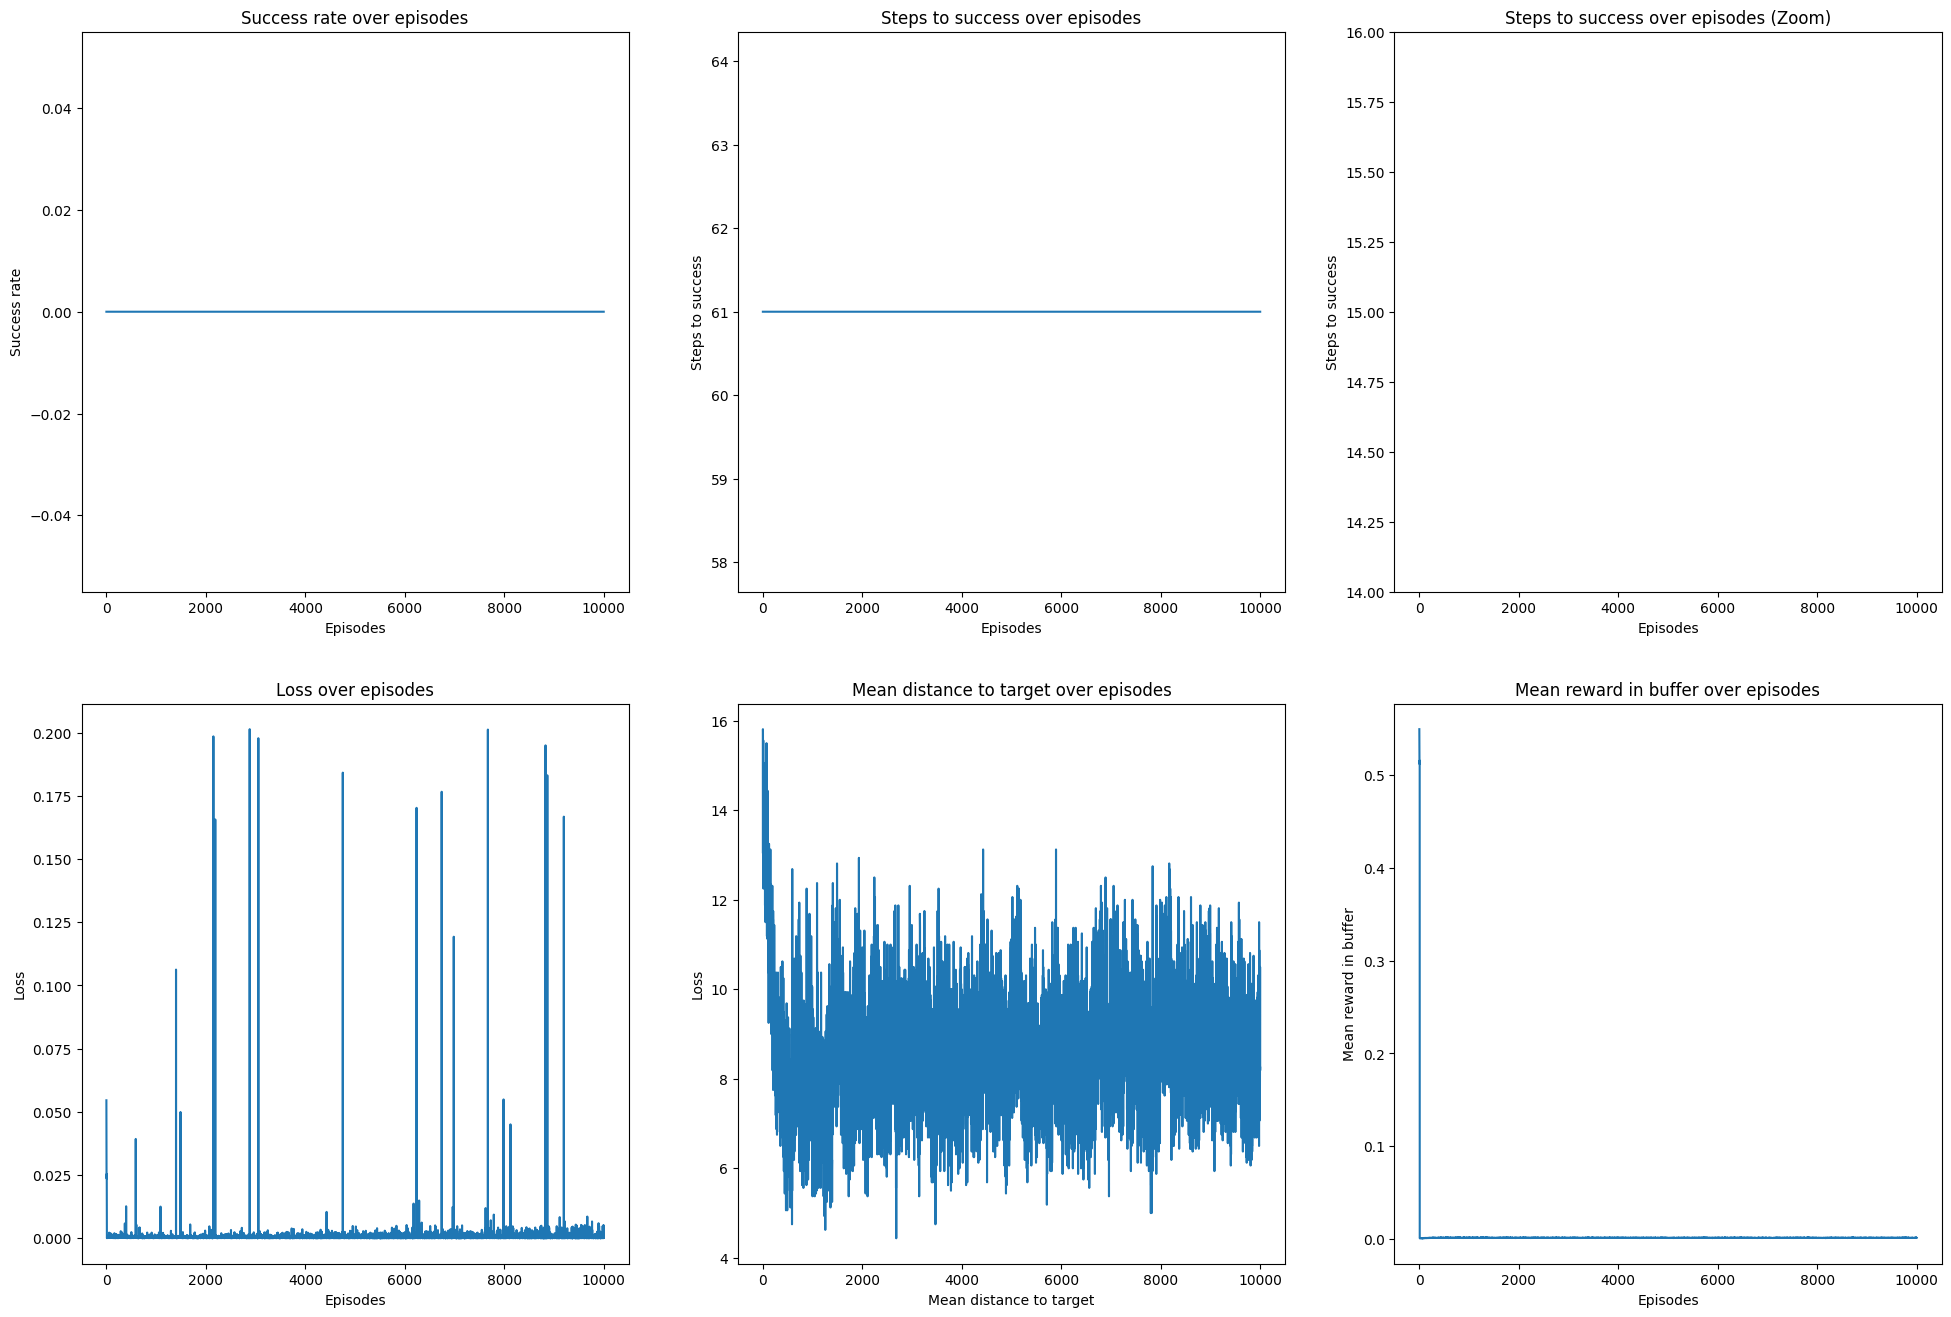

(<src.environments.env_bit_sequence_flipping_goals.FlippingBitSequenceEnvWithGoals at 0x7c3e615070a0>,
 <src.agents.agent_dqn_her.DQNHERAgent at 0x7c3e614c9810>)

In [11]:
train_DQN_HER_agent(30, device=device, episodes=10000, logging_frequency=2000)

Initialized FlippingBitSequenceEnvWithGoals with n = 50. Randomly picked target: tensor([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 0], device='cuda:1')
Initial distance to target: 19
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


 20%|██        | 2000/10000 [13:33<55:12,  2.42it/s]  

Episode: 1999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 101.00, Loss: 0.000239


 40%|████      | 4000/10000 [27:06<41:04,  2.43it/s]

Episode: 3999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 101.00, Loss: 0.000314


 60%|██████    | 6000/10000 [40:52<28:56,  2.30it/s]

Episode: 5999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 101.00, Loss: 0.000207


 80%|████████  | 8000/10000 [54:23<13:28,  2.47it/s]

Episode: 7999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 101.00, Loss: 0.000367


100%|██████████| 10000/10000 [1:07:57<00:00,  2.45it/s]

Episode: 9999/10000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 101.00, Loss: 0.000185


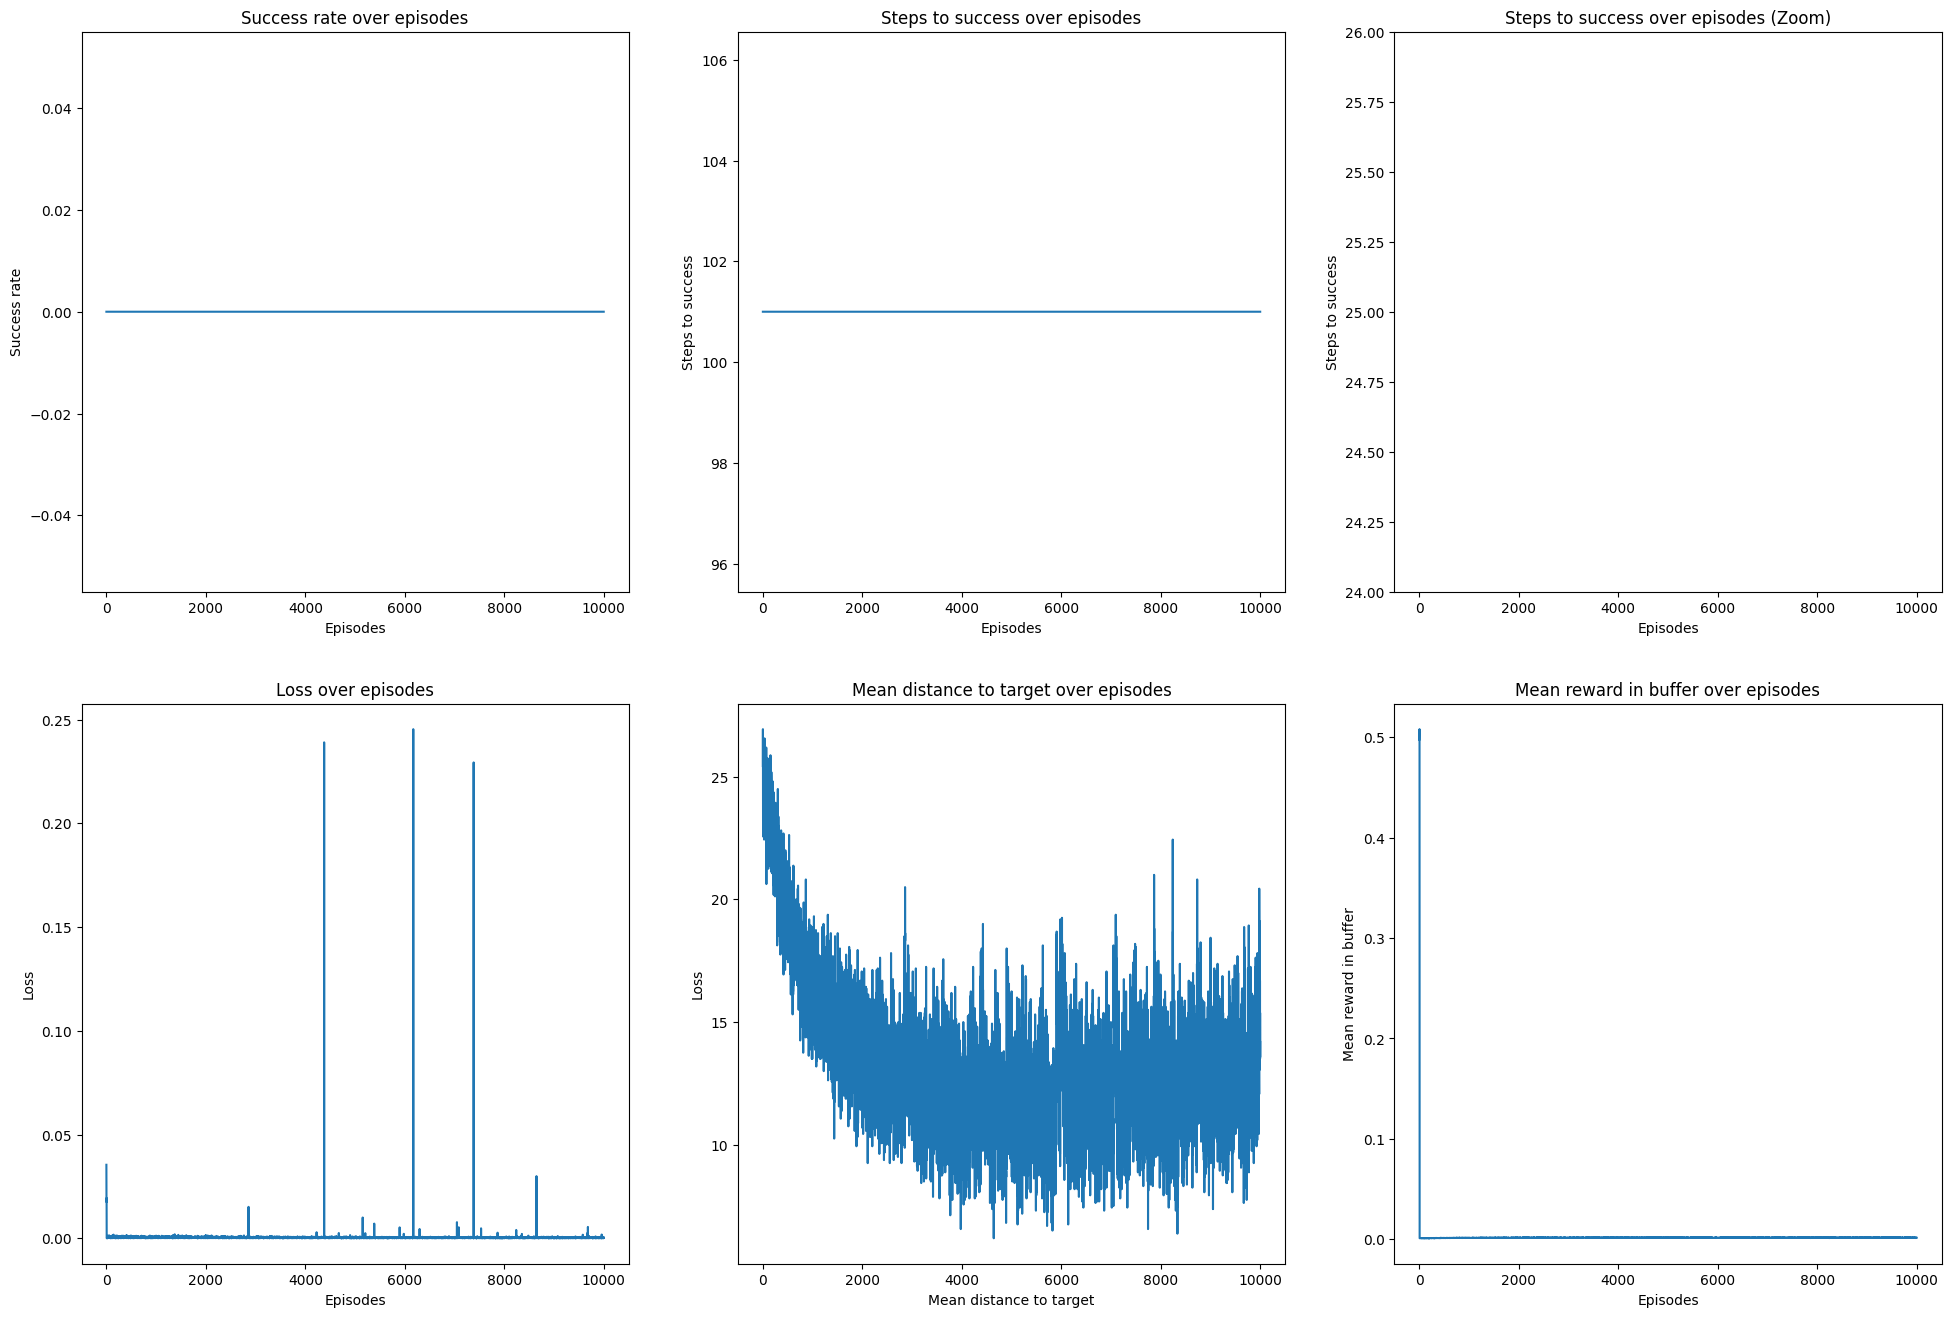

(<src.environments.env_bit_sequence_flipping_goals.FlippingBitSequenceEnvWithGoals at 0x7c3e5edd1ae0>,
 <src.agents.agent_dqn_her.DQNHERAgent at 0x7c3e614ca5f0>)

In [12]:
train_DQN_HER_agent(50, device=device, episodes=10000, logging_frequency=2000)